## Ejemplo de aplicación de Machine Learning con estadísticas de la NBA.
- Reducción de dimensionalidad y técnicas de selección de características.
- Clustering.
- Modelos de machine learning de clasificación.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# imports necesarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import cluster
from scipy.cluster.hierarchy import dendrogram, linkage
import math
import random 
from urllib.request import urlopen
from bs4 import BeautifulSoup

import seaborn as sns
sns.set_style("whitegrid")

import sklearn as skl
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import sklearn.linear_model as linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mutual_info_score
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

Generamos dos listas con los jugadores que fueron en 2019 allstar o estuvieron premiados, y otra lista con los equipos que estuvieron en Playoffs, y así generar dos columnas de tipo 0/1 para marcar cada registro según corresponda. Estas dos columnas podrán usarse como targets para intentar predecirlas con modelos de machine learning.

In [3]:
lista_allstar_premios = ['Kemba Walker', 'Kyrie Irving', 'Kawhi Leonard', 'Giannis Antetokounmpo', 'Joel Embiid', \
    'Kyle Lowry', 'Victor Oladipo', 'Khris Middleton', 'Bradley Beal', 'Ben Simmons', 'Blake Griffin',\
    'Nikola Vucevic', "D'Angelo Russell", 'Stephen Curry', 'James Harden', 'Kevin Durant', 'Paul George',\
    'Lebron James', 'Russell Westbrook', 'Damian Lillard', 'Klay Thompson', 'Anthony Davis', 'LaMarcus Aldridge',\
    'Nikola Jokic', 'Karl-Anthony Towns', 'Rudy Gobert', 'Luka Doncic', 'Pascal Siakam', 'Lou Williams',\
    'Trae Young', 'Deandre Ayton', 'Domantas Sabonis', 'Montrezl Harrell', "De'Aaron Fox", 'Dwyane Wade']

lista_playoffs = ['MIL', 'PHI', 'TOR', 'BOS', 'IND', 'DET', 'ORL', 'BRK', 'GSW',\
    'HOU', 'DEN', 'LAC', 'SAS', 'POR', 'UTA', 'OKC']

#### 1. Carga de los datos, tantos de estadísticas simples como las estadísticas avanzadas. Se generará un dataframe final con ambos tipos de estadísticas y aquellos atributos que queramos tener en cuenta.

In [4]:
# cargar dataframe de estadísticas simples 
df_nba_game = pd.read_csv('./NBA_2019_game.csv', sep=',')
print("Dataset NBA per game: num_rows: %d\tColumnas: %d\n" % (df_nba_game.shape[0], df_nba_game.shape[1]))
print("columns:\n", list(df_nba_game.columns))

Dataset NBA per game: num_rows: 708	Columnas: 30

columns:
 ['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year']


In [5]:
df_nba_game.head(20)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,...,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3,2019
1,Quincy Acy,PF,28,PHO,10,0,12.3,0.4,1.8,0.222,...,0.3,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7,2019
2,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,3.2,0.345,...,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2,2019
3,Steven Adams,C,25,OKC,80,80,33.4,6.0,10.1,0.595,...,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9,2019
4,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,5.9,0.576,...,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9,2019
5,Deng Adel,SF,21,CLE,19,3,10.2,0.6,1.9,0.306,...,0.2,0.8,1.0,0.3,0.1,0.2,0.3,0.7,1.7,2019
6,DeVaughn Akoon-Purcell,SG,25,DEN,7,0,3.1,0.4,1.4,0.300,...,0.1,0.4,0.6,0.9,0.3,0.0,0.3,0.6,1.0,2019
7,LaMarcus Aldridge,C,33,SAS,81,81,33.2,8.4,16.3,0.519,...,3.1,6.1,9.2,2.4,0.5,1.3,1.8,2.2,21.3,2019
8,Rawle Alkins,SG,21,CHI,10,1,12.0,1.3,3.9,0.333,...,1.1,1.5,2.6,1.3,0.1,0.0,0.8,0.7,3.7,2019
9,Grayson Allen,SG,23,UTA,38,2,10.9,1.8,4.7,0.376,...,0.1,0.5,0.6,0.7,0.2,0.2,0.9,1.2,5.6,2019


In [6]:
# cargamos datos con las estadísticas avanzadas
df_nba_advanced = pd.read_csv('./NBA_2019_advanced.csv', sep=',')
print("Dataset NBA per game: num_rows: %d\tColumnas: %d\n" % (df_nba_advanced.shape[0], df_nba_advanced.shape[1]))
print("columns:\n", list(df_nba_advanced.columns))

Dataset NBA per game: num_rows: 708	Columnas: 27

columns:
 ['Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Year']


In [7]:
df_nba_advanced.head(20)

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Year
0,Álex Abrines,SG,25,OKC,31,588,6.3,0.507,0.809,0.083,...,12.2,0.1,0.6,0.6,0.053,-2.4,-0.9,-3.4,-0.2,2019
1,Quincy Acy,PF,28,PHO,10,123,2.9,0.379,0.833,0.556,...,9.2,-0.1,0.0,-0.1,-0.022,-5.7,-0.3,-5.9,-0.1,2019
2,Jaylen Adams,PG,22,ATL,34,428,7.6,0.474,0.673,0.082,...,13.5,-0.1,0.2,0.1,0.011,-3.1,-1.3,-4.4,-0.3,2019
3,Steven Adams,C,25,OKC,80,2669,18.5,0.591,0.002,0.361,...,16.4,5.1,4.0,9.1,0.163,0.6,2.1,2.7,3.2,2019
4,Bam Adebayo,C,21,MIA,82,1913,17.9,0.623,0.031,0.465,...,15.8,3.4,3.4,6.8,0.171,-0.6,3.6,3.0,2.4,2019
5,Deng Adel,SF,21,CLE,19,194,2.7,0.424,0.639,0.111,...,9.9,-0.2,0.0,-0.2,-0.054,-5.3,-2.0,-7.3,-0.3,2019
6,DeVaughn Akoon-Purcell,SG,25,DEN,7,22,8.2,0.322,0.400,0.200,...,25.0,-0.1,0.0,0.0,-0.051,-4.4,0.8,-3.6,0.0,2019
7,LaMarcus Aldridge,C,33,SAS,81,2687,22.9,0.576,0.032,0.312,...,26.9,6.4,2.9,9.3,0.167,1.2,0.5,1.6,2.5,2019
8,Rawle Alkins,SG,21,CHI,10,120,8.1,0.418,0.308,0.308,...,19.0,-0.1,0.0,-0.1,-0.042,-4.1,-2.5,-6.5,-0.1,2019
9,Grayson Allen,SG,23,UTA,38,416,7.5,0.516,0.556,0.337,...,24.4,-0.4,0.4,0.0,0.002,-3.7,-3.1,-6.8,-0.5,2019


#### Creación del dataset final. Ver las columnas/atributos con las que nos quedaremos.

###### Datasets estadísticas por partido
- Pos -- Position
- Age -- Age of Player at the start of February 1st of that season.
- Tm -- Team
- G -- Games
- GS -- Games Started
- MP -- Minutes Played Per Game
- FG -- Field Goals Per Game
- FGA -- Field Goal Attempts Per Game
- FG% -- Field Goal Percentage
- 3P -- 3-Point Field Goals Per Game
- 3PA -- 3-Point Field Goal Attempts Per Game
- 3P% -- 3-Point Field Goal Percentage
- 2P -- 2-Point Field Goals Per Game
- 2PA -- 2-Point Field Goal Attempts Per Game
- 2P% -- 2-Point Field Goal Percentage
- eFG% -- Effective Field Goal Percentage
- FT -- Free Throws Per Game
- FTA -- Free Throw Attempts Per Game
- FT% -- Free Throw Percentage
- ORB -- Offensive Rebounds Per Game
- DRB -- Defensive Rebounds Per Game
- TRB -- Total Rebounds Per Game
- AST -- Assists Per Game
- STL -- Steals Per Game
- BLK -- Blocks Per Game
- TOV -- Turnovers Per Game
- PF -- Personal Fouls Per Game
- PTS -- Points Per Game


###### Datasets estadísticas avanzadas
- Pos -- Position
- Age -- Age of Player at the start of February 1st of that season.
- Tm -- Team
- G -- Games
- MP -- Minutes Played
- PER -- Player Efficiency Rating. Una medida de producción por minuto estandarizada de modo que el promedio de la liga sea 15.
- TS% -- True Shooting Percentage. Porcentaje de tiro real. Una medida de eficiencia de tiro que tiene en cuenta los tiros de 2 puntos, los tiros de 3 puntos y los tiros libres.
- 3PAr -- 3-Point Attempt Rate. Porcentaje de intentos de FG desde el rango de 3 puntos.
- FTr -- Free Throw Attempt Rate. Número de intentos de FT por intento de FG.
- ORB% -- Offensive Rebound Percentage. Porcentaje de rebote ofensivo. Una estimación del porcentaje de rebotes ofensivos disponibles que un jugador agarró mientras estaba jugando.
- DRB% -- Defensive Rebound Percentage. Porcentaje de rebote defensivo. Una estimación del porcentaje de rebotes defensivos disponibles que un jugador agarró mientras estaba jugando.
- TRB% -- Total Rebound Percentage. Porcentaje de rebote total. Una estimación del porcentaje de rebotes disponibles que un jugador agarró mientras estaba jugando.
- AST% -- Assist Percentage. Porcentaje de asistencia. Una estimación del porcentaje de canastas de compañeros de equipo a los que ayudó un jugador mientras estaba jugando.
- STL% -- Steal Percentage. Porcentaje de robo. Una estimación del porcentaje de posesiones del oponente que termina con un robo por parte del jugador mientras estaba jugando.
- BLK% -- Block Percentage. Porcentaje de bloqueo. Una estimación del porcentaje de intentos de tiros de campo de dos puntos del oponente bloqueados por el jugador mientras estaba jugando.
- TOV% -- Turnover Percentage. Porcentaje de pérdidas. Una estimación de pérdidas de balón cometidas por cada 100 jugadas.
- USG% -- Usage Percentage. Porcentaje de uso. Una estimación del porcentaje de jugadas de equipo utilizadas por un jugador mientras estaba jugando.
- OWS -- Offensive Win Shares. Acciones ofensivas de victoria. Una estimación del número de victorias aportadas por un jugador debido a su ataque.
- DWS -- Defensive Win Shares. Acciones de victoria defensivas. Una estimación del número de victorias aportadas por un jugador debido a su defensa.
- WS -- Win Shares. Una estimación del número de victorias aportadas por un jugador.
- WS/48 -- Win Shares Per 48 Minutes. Una estimación del número de victorias aportadas por un jugador por 48 minutos (el promedio de la liga es aproximadamente .100)
- OBPM -- Offensive Box Plus/Minus. Una estimación de puntuación mas/menos de los puntos ofensivos por 100 posesiones que un jugador contribuyó por encima de un jugador promedio de la liga, traducido a un equipo promedio.
- DBPM -- Defensive Box Plus/Minus. Una estimación de puntuación mas/menos de los puntos defensivos por 100 posesiones que un jugador contribuyó por encima de un jugador promedio de la liga, traducido a un equipo promedio.
- BPM -- Box Plus/Minus. Una estimación de puntuación mas/menos de los puntos por 100 posesiones que un jugador contribuyó por encima de un jugador promedio de la liga, traducido a un equipo promedio.
- VORP -- Value over Replacement Player. Valor sobre el jugador de reemplazo. Una estimación de puntuación mas/menos de los puntos por 100 posesiones de EQUIPO que un jugador contribuyó por encima de un jugador de nivel de reemplazo (-2.0), traducido a un equipo promedio y prorrateado a una temporada de 82 juegos. Multiplique por 2.70 para convertir a victorias sobre reemplazo.

In [8]:
# nos quedamos con las columnas del dataset de estadísticas avanzadas que no estén en el de datos simples. 
# eliminamos antes del merge las columnas que comparten.
cols_to_use_adv = df_nba_advanced.columns.difference(df_nba_game.columns)

In [9]:
cols_to_use_adv

Index(['3PAr', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DRB%', 'DWS', 'FTr', 'OBPM',
       'ORB%', 'OWS', 'PER', 'STL%', 'TOV%', 'TRB%', 'TS%', 'USG%', 'VORP',
       'WS', 'WS/48'],
      dtype='object')

In [10]:
# juntar ambos datasets para tener las estadísticas tradicionales y las avanzadas de cada jugador
df_result = pd.merge(df_nba_game,
                  df_nba_advanced[cols_to_use_adv], 
                  left_index=True, right_index=True)

In [11]:
df_result.head(20)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,OWS,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48
0,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,...,0.1,6.3,1.3,7.9,4.2,0.507,12.2,-0.2,0.6,0.053
1,Quincy Acy,PF,28,PHO,10,0,12.3,0.4,1.8,0.222,...,-0.1,2.9,0.4,15.2,11.3,0.379,9.2,-0.1,-0.1,-0.022
2,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,3.2,0.345,...,-0.1,7.6,1.5,19.7,7.4,0.474,13.5,-0.3,0.1,0.011
3,Steven Adams,C,25,OKC,80,80,33.4,6.0,10.1,0.595,...,5.1,18.5,2.0,12.6,14.7,0.591,16.4,3.2,9.1,0.163
4,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,5.9,0.576,...,3.4,17.9,1.8,17.1,16.6,0.623,15.8,2.4,6.8,0.171
5,Deng Adel,SF,21,CLE,19,3,10.2,0.6,1.9,0.306,...,-0.2,2.7,0.3,13.7,5.4,0.424,9.9,-0.3,-0.2,-0.054
6,DeVaughn Akoon-Purcell,SG,25,DEN,7,0,3.1,0.4,1.4,0.300,...,-0.1,8.2,4.5,15.5,9.8,0.322,25.0,0.0,0.0,-0.051
7,LaMarcus Aldridge,C,33,SAS,81,81,33.2,8.4,16.3,0.519,...,6.4,22.9,0.8,8.8,15.1,0.576,26.9,2.5,9.3,0.167
8,Rawle Alkins,SG,21,CHI,10,1,12.0,1.3,3.9,0.333,...,-0.1,8.1,0.4,15.3,11.8,0.418,19.0,-0.1,-0.1,-0.042
9,Grayson Allen,SG,23,UTA,38,2,10.9,1.8,4.7,0.376,...,-0.4,7.5,0.7,13.9,3.0,0.516,24.4,-0.5,0.0,0.002


In [12]:
# usamos dos funciones para recorrer los registros del dataframe y si el equipo o el jugador de dicho registro
# coincide con uno de los definidos en las listas formadas al inicio, poner el valor 0 o 1 según corresponda en dos
# nuevas columnas 'PO_class' y 'AS_class'. Si el jugador de un registro está en un equipo que estuvo en playoffs se
# pondrá un valor 1 en la primera columna nueva, y si ese jugador estuvo premiado o fue allstar se pone un 1 en la
# segunda columna nueva.
def f_po(row):
    if row["Tm"] in lista_playoffs:
        return 1
    else:
        return 0
    print(row)
    
def f_as(row):
    if row["Player"] in lista_allstar_premios:
        return 1
    else:
        return 0
    print(row)

df_result['PO_class'] = df_result.apply(f_po, axis=1)
df_result['AS_class'] = df_result.apply(f_as, axis=1)

In [13]:
df_result.head(20)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,PO_class,AS_class
0,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,...,1.3,7.9,4.2,0.507,12.2,-0.2,0.6,0.053,1,0
1,Quincy Acy,PF,28,PHO,10,0,12.3,0.4,1.8,0.222,...,0.4,15.2,11.3,0.379,9.2,-0.1,-0.1,-0.022,0,0
2,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,3.2,0.345,...,1.5,19.7,7.4,0.474,13.5,-0.3,0.1,0.011,0,0
3,Steven Adams,C,25,OKC,80,80,33.4,6.0,10.1,0.595,...,2.0,12.6,14.7,0.591,16.4,3.2,9.1,0.163,1,0
4,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,5.9,0.576,...,1.8,17.1,16.6,0.623,15.8,2.4,6.8,0.171,0,0
5,Deng Adel,SF,21,CLE,19,3,10.2,0.6,1.9,0.306,...,0.3,13.7,5.4,0.424,9.9,-0.3,-0.2,-0.054,0,0
6,DeVaughn Akoon-Purcell,SG,25,DEN,7,0,3.1,0.4,1.4,0.300,...,4.5,15.5,9.8,0.322,25.0,0.0,0.0,-0.051,1,0
7,LaMarcus Aldridge,C,33,SAS,81,81,33.2,8.4,16.3,0.519,...,0.8,8.8,15.1,0.576,26.9,2.5,9.3,0.167,1,1
8,Rawle Alkins,SG,21,CHI,10,1,12.0,1.3,3.9,0.333,...,0.4,15.3,11.8,0.418,19.0,-0.1,-0.1,-0.042,0,0
9,Grayson Allen,SG,23,UTA,38,2,10.9,1.8,4.7,0.376,...,0.7,13.9,3.0,0.516,24.4,-0.5,0.0,0.002,1,0


In [14]:
# borramos los registros donde el equipo sea 'TOT'. Este valor corresponde a jugadores que jugaron el año pasado
# en más de un equipo, y en el dataframe aparecen sus datos en cada equipo, y luego en total, así que este total
# no nos hace falta.
df_result = df_result.drop(df_result[df_result['Tm']=='TOT'].index)

In [15]:
df_result.head(20)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,PO_class,AS_class
0,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,0.357,...,1.3,7.9,4.2,0.507,12.2,-0.2,0.6,0.053,1,0
1,Quincy Acy,PF,28,PHO,10,0,12.3,0.4,1.8,0.222,...,0.4,15.2,11.3,0.379,9.2,-0.1,-0.1,-0.022,0,0
2,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,3.2,0.345,...,1.5,19.7,7.4,0.474,13.5,-0.3,0.1,0.011,0,0
3,Steven Adams,C,25,OKC,80,80,33.4,6.0,10.1,0.595,...,2.0,12.6,14.7,0.591,16.4,3.2,9.1,0.163,1,0
4,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,5.9,0.576,...,1.8,17.1,16.6,0.623,15.8,2.4,6.8,0.171,0,0
5,Deng Adel,SF,21,CLE,19,3,10.2,0.6,1.9,0.306,...,0.3,13.7,5.4,0.424,9.9,-0.3,-0.2,-0.054,0,0
6,DeVaughn Akoon-Purcell,SG,25,DEN,7,0,3.1,0.4,1.4,0.300,...,4.5,15.5,9.8,0.322,25.0,0.0,0.0,-0.051,1,0
7,LaMarcus Aldridge,C,33,SAS,81,81,33.2,8.4,16.3,0.519,...,0.8,8.8,15.1,0.576,26.9,2.5,9.3,0.167,1,1
8,Rawle Alkins,SG,21,CHI,10,1,12.0,1.3,3.9,0.333,...,0.4,15.3,11.8,0.418,19.0,-0.1,-0.1,-0.042,0,0
9,Grayson Allen,SG,23,UTA,38,2,10.9,1.8,4.7,0.376,...,0.7,13.9,3.0,0.516,24.4,-0.5,0.0,0.002,1,0


Vamos a eliminar ciertas columnas que pensemos que son menos importantes para los posteriores análisis y los modelos, y además para tener menos atributos ya que es más costoso trabajar con un número elevado de atributos o columnas. 
Eliminamos las siguientes columnas: Pos -posición del jugador-, Age -edad del jugador-, Year -año de los datos-, Tm -equipo del jugador-, G -partidos jugados-, FG -tiros de campo anotados-, FGA -tiros de campo intentados-, 3P -tiros de 3 anotados-, 3PA -tiros de 3 intentados-, 2P -tiros de 2 anotados-, 2PA -tiros de 2 intentados-, FT -tiros libros anotados-, FTA -tiros libres intentados-, ORB -rebotes ofensivos-, DRB -rebotes defensivos-, PF -faltas personales-.
No tendremos en cuenta los tiros anotados e intentados, porque en las avanzadas hay otros indicadores más fiables del tiro y sus porcentajes.

In [16]:
# eliminar columnas que pensemos que son menos importantes para tener menos atributos con los que trabajar
df_result = df_result.drop(columns=['Pos','Age','Year','Tm','G','FG','FGA','3P','3PA','2P','2PA','FT','FTA','ORB',\
                                   'DRB','PF'], axis=1)

In [17]:
# ver si hay datos vacíos o nulos. La columna que no tiene valores vacíos o nulos tendrá valor 'True'
df_result.notnull().all()

Player       True
GS           True
MP           True
FG%         False
3P%         False
2P%         False
eFG%        False
FT%         False
TRB          True
AST          True
STL          True
BLK          True
TOV          True
PTS          True
3PAr        False
AST%         True
BLK%         True
BPM          True
DBPM         True
DRB%         True
DWS          True
FTr         False
OBPM         True
ORB%         True
OWS          True
PER          True
STL%         True
TOV%        False
TRB%         True
TS%         False
USG%         True
VORP         True
WS           True
WS/48        True
PO_class     True
AS_class     True
dtype: bool

Como vemos hay varias columnas con datos vacíos o nulos, así que ahora vamos a rellenar dichos valores con la media de ese atributo y con la moda, según el tipo de dato sea cuantitativo o categórico.

In [18]:
# Agrupando columnas por tipo de datos
tipos = df_result.columns.to_series().groupby(df_result.dtypes).groups

# Lista de columnas categóricas
ctext = tipos[np.dtype('object')]
# Lista de columnas numéricas
columnas = df_result.columns 
cnum = list(set(columnas) - set(ctext))

print("Columnas categóricas:\n",ctext)
print("\n")
print("Columnas numéricas:\n",cnum)

Columnas categóricas:
 Index(['Player'], dtype='object')


Columnas numéricas:
 ['STL%', '3P%', 'ORB%', 'VORP', 'STL', 'eFG%', 'PTS', 'AST', 'AS_class', 'TS%', 'TOV', 'DWS', 'PO_class', 'DRB%', 'WS', 'BLK%', 'USG%', 'BPM', 'TRB%', '3PAr', 'MP', 'FT%', 'OBPM', 'TOV%', 'DBPM', 'WS/48', 'FG%', 'BLK', 'FTr', 'AST%', '2P%', 'PER', 'OWS', 'GS', 'TRB']


In [19]:
# Completando valores faltantes de datos cuantitativos
for c in cnum:
    mean = df_result[c].mean()
    df_result[c] = df_result[c].fillna(mean)
    
# Completando valores faltantes de datos categóricos
for c in ctext:
    mode = df_result[c].mode()[0]
    df_result[c] = df_result[c].fillna(mode)

In [20]:
# Otra forma de ver si hay datos vacíos o nulos, debe salir 'false' para saber que no los hay.
df_result.isnull().any().any()

False

In [21]:
# Una vez no hay datos vacíos o nulos, por ejemplo usamos 'describe' para dar un simple vistazo a las medidas
# estadísticas más comunes, para ver una primera distribución de los datos.
df_result.describe().T

,count,mean,std,min,25%,50%,75%,max
GS,622.0,19.774920,26.200346,0.000,0.00000,5.0000,32.00000,82.000
MP,622.0,19.220579,9.204835,0.700,12.00000,19.0500,27.20000,36.900
FG%,622.0,0.438144,0.113449,0.000,0.40000,0.4380,0.48600,1.000
3P%,622.0,0.313818,0.136472,0.000,0.28625,0.3330,0.36900,1.000
2P%,622.0,0.493410,0.121222,0.000,0.45500,0.5000,0.55050,1.000
eFG%,622.0,0.500537,0.122925,0.000,0.46925,0.5100,0.55275,1.500
FT%,622.0,0.736637,0.142857,0.000,0.68575,0.7500,0.81900,1.000
TRB,622.0,3.559003,2.526824,0.000,1.80000,3.0000,4.70000,15.600
AST,622.0,1.865113,1.708845,0.000,0.72500,1.3000,2.47500,10.700
STL,622.0,0.608842,0.426236,0.000,0.30000,0.5000,0.90000,2.400


In [22]:
# Visualizamos el número de registros y columnas del dataset final.
print("Dataset final: num_rows: %d\tColumnas: %d\n" % (df_result.shape[0], df_result.shape[1]))
print("columns:\n", list(df_result.columns))

Dataset final: num_rows: 622	Columnas: 36

columns:
 ['Player', 'GS', 'MP', 'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', '3PAr', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DRB%', 'DWS', 'FTr', 'OBPM', 'ORB%', 'OWS', 'PER', 'STL%', 'TOV%', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48', 'PO_class', 'AS_class']


#### 2. Reducción de dimensionalidad e información no estructurada.

#### 2.1 Detectar las variables más informativas utilizando algún método de selección de características por filtrado.

In [23]:
# dividimos variable target y predictoras. La variable target será la 'AS_class', que identifica los jugadores
# que ganaron algún premio o que estuvieron en alguno de los mejores quintetos de la temporada.
vars_nba = list(df_result.columns[1:-1])
target_nba = df_result.columns[-1]
print(vars_nba)
print(target_nba)

['GS', 'MP', 'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', '3PAr', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DRB%', 'DWS', 'FTr', 'OBPM', 'ORB%', 'OWS', 'PER', 'STL%', 'TOV%', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48', 'PO_class']
AS_class


In [24]:
# hacemos una copia del dataset original y eliminamos la columna del nombre del jugador, ya que algunos métodos
# posteriores no pueden recibir datos en formato string.
df_result_copy = df_result.copy()
df_result_copy = df_result_copy.drop(columns=['Player'], axis=1)

In [25]:
df_result_copy.head()

,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,...,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,PO_class,AS_class
0,2,19.0,0.357,0.323,0.500,0.487,0.923,1.5,0.6,0.5,...,1.3,7.9,4.2,0.507,12.2,-0.2,0.6,0.053,1,0
1,0,12.3,0.222,0.133,0.667,0.278,0.700,2.5,0.8,0.1,...,0.4,15.2,11.3,0.379,9.2,-0.1,-0.1,-0.022,0,0
2,1,12.6,0.345,0.338,0.361,0.459,0.778,1.8,1.9,0.4,...,1.5,19.7,7.4,0.474,13.5,-0.3,0.1,0.011,0,0
3,80,33.4,0.595,0.000,0.596,0.595,0.500,9.5,1.6,1.5,...,2.0,12.6,14.7,0.591,16.4,3.2,9.1,0.163,1,0
4,28,23.3,0.576,0.200,0.588,0.579,0.735,7.3,2.2,0.9,...,1.8,17.1,16.6,0.623,15.8,2.4,6.8,0.171,0,0


In [26]:
# se añade variables dummys de ruido y se separan los datos en train y test
nruidos = 15
noise = np.random.uniform(0, 1., size=(len(df_result_copy), nruidos))
X = np.hstack((df_result_copy, noise))
y = df_result_copy[target_nba]
nombres_atributos = list(df_result_copy.columns[0:-1])

for i in np.arange(1,nruidos+1):
    nombres_atributos.append("noise_%d" % i)

print (nombres_atributos)

# training /test split
testsize = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=5)

['GS', 'MP', 'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', '3PAr', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DRB%', 'DWS', 'FTr', 'OBPM', 'ORB%', 'OWS', 'PER', 'STL%', 'TOV%', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48', 'PO_class', 'noise_1', 'noise_2', 'noise_3', 'noise_4', 'noise_5', 'noise_6', 'noise_7', 'noise_8', 'noise_9', 'noise_10', 'noise_11', 'noise_12', 'noise_13', 'noise_14', 'noise_15']


In [27]:
# funciones necesarias para los métodos de selección de características. Aplicaremos dos métodos distintos para
# la clasificación de atributos.

# función para ver si un atributo es de tipo categórico
def is_categorical(array_like):
    return array_like.dtype.name == 'category'


# función para aplicar el método de mutual information
def mutual_information(x, y, bins):
    return mutual_info_score(None, None, contingency=np.histogram2d(x, y, bins)[0])


# función que aplica a los datos que le pasemos el método de selección de características indicado
def ranking_variables_clasificacion(X, y, nombres, metodo, draw=False):
    nvars = np.shape(X)[1]
    nvars = nvars-1
    
    if metodo == "mutual_info":
        for nom in nombres:
            if (nom in vars_nba and not is_categorical(df_result_copy[nom])) or \
            (nom not in vars_nba):  
                if nom in vars_nba:
                    nbinsx = np.sqrt(len(X)/5)
                else:
                    nbinsx = 5
            else:
                nbinsx = np.shape(np.unique(y))[-1]
        nbinsy = np.shape(np.unique(y))[-1]
        bins = (nbinsx, nbinsy)
        scores = np.zeros(nvars)
        for i in np.arange(0,nvars):
            scores[i] = mutual_information(X[:,i].astype(float),y,bins)
    
    elif metodo == "corr":
        scores = np.zeros(nvars)
        aux = y.T
        for i in np.arange(0,nvars):
            scores[i] = np.corrcoef(X[:,i].T.astype(float),aux)[0][1] ** 2

    inds = np.argsort(scores)[::-1]

    for ind in inds:
        print("%s \t score=%f \t" % (nombres[ind], scores[ind]))

In [28]:
# método de mutual information
ranking_variables_clasificacion(X_train,y_train,nombres_atributos,"mutual_info")

noise_1 	 score=0.200204 	
PTS 	 score=0.124961 	
VORP 	 score=0.112879 	
WS 	 score=0.099953 	
TOV 	 score=0.091361 	
DWS 	 score=0.087215 	
OWS 	 score=0.086090 	
MP 	 score=0.079368 	
USG% 	 score=0.076405 	
GS 	 score=0.071516 	
TRB 	 score=0.063622 	
BPM 	 score=0.061621 	
AST 	 score=0.055228 	
OBPM 	 score=0.052919 	
PER 	 score=0.050386 	
STL 	 score=0.049623 	
AST% 	 score=0.040693 	
BLK 	 score=0.029182 	
WS/48 	 score=0.017876 	
FG% 	 score=0.016261 	
TOV% 	 score=0.015574 	
TS% 	 score=0.015140 	
STL% 	 score=0.009983 	
noise_8 	 score=0.008165 	
noise_14 	 score=0.007842 	
2P% 	 score=0.007730 	
DBPM 	 score=0.007545 	
FTr 	 score=0.007360 	
noise_9 	 score=0.006378 	
noise_3 	 score=0.006228 	
3PAr 	 score=0.006140 	
DRB% 	 score=0.005082 	
TRB% 	 score=0.004548 	
BLK% 	 score=0.004214 	
eFG% 	 score=0.003966 	
PO_class 	 score=0.003919 	
noise_7 	 score=0.003843 	
FT% 	 score=0.003538 	
noise_13 	 score=0.002995 	
noise_12 	 score=0.002993 	
noise_15 	 score=0.002690 	
n

In [29]:
# método corr
ranking_variables_clasificacion(X_train,y_train,nombres_atributos,"corr")

noise_1 	 score=1.000000 	
VORP 	 score=0.467173 	
WS 	 score=0.362833 	
OWS 	 score=0.353743 	
PTS 	 score=0.283397 	
TOV 	 score=0.266558 	
DWS 	 score=0.257599 	
AST 	 score=0.205476 	
GS 	 score=0.179916 	
TRB 	 score=0.152769 	
USG% 	 score=0.137239 	
STL 	 score=0.135027 	
MP 	 score=0.116733 	
PER 	 score=0.109495 	
BLK 	 score=0.098768 	
AST% 	 score=0.095389 	
BPM 	 score=0.079856 	
OBPM 	 score=0.077096 	
WS/48 	 score=0.040347 	
DBPM 	 score=0.026794 	
FG% 	 score=0.016926 	
DRB% 	 score=0.015819 	
3PAr 	 score=0.014444 	
FTr 	 score=0.013613 	
TS% 	 score=0.012711 	
TRB% 	 score=0.011635 	
STL% 	 score=0.011546 	
2P% 	 score=0.009183 	
eFG% 	 score=0.008162 	
BLK% 	 score=0.007910 	
PO_class 	 score=0.007683 	
noise_8 	 score=0.005692 	
noise_2 	 score=0.004552 	
FT% 	 score=0.004072 	
noise_15 	 score=0.003965 	
noise_14 	 score=0.003444 	
noise_12 	 score=0.003436 	
noise_7 	 score=0.003323 	
noise_9 	 score=0.001384 	
noise_11 	 score=0.001051 	
noise_10 	 score=0.000836

**Comentarios**

Los atributos que según los métodos usados tienen más impacto o información más relevante para el atributo target serían los siguientes:

Mutual information: PTS, VORP, WS, TOV, DWS, OWS, MP, USG%, GS, TRB, BPM, AST, OBPM, PER.

Corr: VORP,WS,OWS,PTS,TOV,DWS,AST,GS,TRB,USG%,STL,MP,PER.

Se puede apreciar como con ambos métodos más o menos son las mismas características las que aparecen como más importantes, como pueden ser VORP, WS o el promedio de puntos del jugador.

**2.2 Realizar ese mismo análisis utilizando ahora alguno de los métodos de Selección de Características por wrapping.**

Otra estrategia: entrenar un modelo auxiliar que esté también diseñado para dar la importancia de los atributos, y así seleccionarlos usando esta información.

In [30]:
# se entrena un modelo kNN para clasificar las características en grado a su importancia
aux1 = ExtraTreesClassifier(n_estimators = 21)
aux1.fit(X_train, y_train)

aux2 = SelectFromModel(aux1, prefit=True)
inds_elegidos = np.where(aux2.get_support())[0]
print("\nElegidos:")
print(np.array(nombres_atributos)[inds_elegidos])

X_train_red = X_train[:,inds_elegidos]
X_test_red = X_test[:,inds_elegidos]

my_model = kNN()
my_model.fit(X_train_red,y_train)

print('Score de my_model en train: %.3f' % my_model.score(X_train_red, y_train))
print('Score de my_model en test : %.3f' % my_model.score(X_test_red, y_test))


Elegidos:
['TOV' 'PTS' 'OWS' 'PER' 'VORP' 'WS' 'noise_1']
Score de my_model en train: 0.977
Score de my_model en test : 0.968


**Comentarios**

Con el uso del modelo auxiliar, apreciamos como vuelven a aparecer como algunas de las características más importantes VORP, WS o los puntos.

**2.3 Visualizar la proyección de los datos en los primeros componentes principales obtenidos por PCA, junto a la proyección de las variables originales.**

In [31]:
# separamos los datos en variables y target, y en datos para train y test.
X = df_result_copy
y = df_result_copy[target_nba]
nombres_atributos = list(df_result_copy.columns[0:])

print (nombres_atributos)

# training /test split
testsize = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=5)

['GS', 'MP', 'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', '3PAr', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DRB%', 'DWS', 'FTr', 'OBPM', 'ORB%', 'OWS', 'PER', 'STL%', 'TOV%', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48', 'PO_class', 'AS_class']


In [32]:
# aplicamos la técnica PCA para obtener los componentes principales que maximizan la varianza de los datos
X_std = StandardScaler().fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_std)

print()
print('-- Estadísticas de los datos proyectados en las componentes principales --')
print()

for i in range(X_pca.shape[1]):
    print("* Datos en componente principal", i+1, ":")
    print("  - Media    :", X_pca[:,i].mean().round(3))
    print("  - Varianza :", X_pca[:,i].var(ddof=1).round(3))
    print("  - Autovalor:", pca.explained_variance_[i].round(3))
    print("  - Varianza explicada:", (100*pca.explained_variance_ratio_[i]).round(3), "%")
    print()


-- Estadísticas de los datos proyectados en las componentes principales --

* Datos en componente principal 1 :
  - Media    : 0.0
  - Varianza : 11.303
  - Autovalor: 11.303
  - Varianza explicada: 32.241 %

* Datos en componente principal 2 :
  - Media    : -0.0
  - Varianza : 4.467
  - Autovalor: 4.467
  - Varianza explicada: 12.744 %

* Datos en componente principal 3 :
  - Media    : -0.0
  - Varianza : 3.963
  - Autovalor: 3.963
  - Varianza explicada: 11.306 %

* Datos en componente principal 4 :
  - Media    : 0.0
  - Varianza : 2.06
  - Autovalor: 2.06
  - Varianza explicada: 5.875 %

* Datos en componente principal 5 :
  - Media    : -0.0
  - Varianza : 1.949
  - Autovalor: 1.949
  - Varianza explicada: 5.559 %

* Datos en componente principal 6 :
  - Media    : 0.0
  - Varianza : 1.465
  - Autovalor: 1.465
  - Varianza explicada: 4.179 %

* Datos en componente principal 7 :
  - Media    : -0.0
  - Varianza : 1.25
  - Autovalor: 1.25
  - Varianza explicada: 3.566 %

* Datos 

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


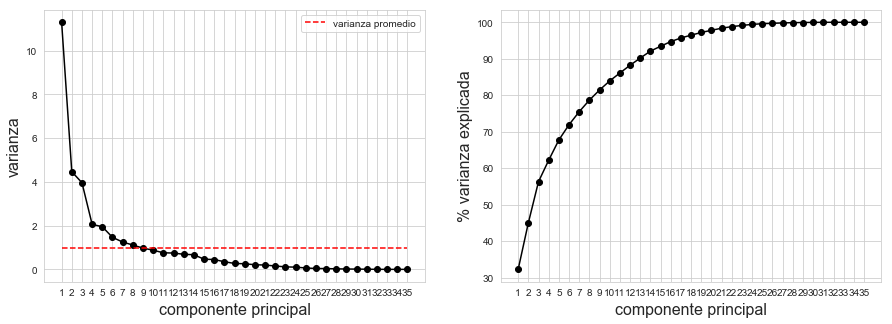

In [33]:
# graficamos las componentes principales obtenidas 
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(1,pca.n_components_+1), pca.explained_variance_, '-ok')
plt.plot([1,pca.n_components_], [1,1], '--r', label='varianza promedio')
plt.legend()
plt.xlabel('componente principal', fontsize=16)
plt.ylabel('varianza', fontsize=16)
plt.xticks(range(1,pca.n_components_+1))

plt.subplot(1,2,2)
plt.plot(range(1,pca.n_components_+1),
         100*pca.explained_variance_ratio_.cumsum(), '-ok')
plt.xlabel('componente principal', fontsize=16)
plt.ylabel('% varianza explicada', fontsize=16)
plt.xticks(range(1,pca.n_components_+1))
plt.show()

**Comentarios**

Viendo las gráficas, vemos como hay unas 8 componentes principales con un autovalor al menos de 1, el cual suele considerarse como válido para tener esa componente en cuenta.

Luego teniendo en cuenta la varianza de los datos que explican las componentes, el 90% se alcanza con 13 componentes, y el 80% con 8.

Con lo cual, quedándonos con 13 componentes ya tendriamos el 90% de varianza de los datos y sería más que suficiente.

In [34]:
pcs_names = ['componente principal '+str(i+1) for i in range(pca.n_components_)]

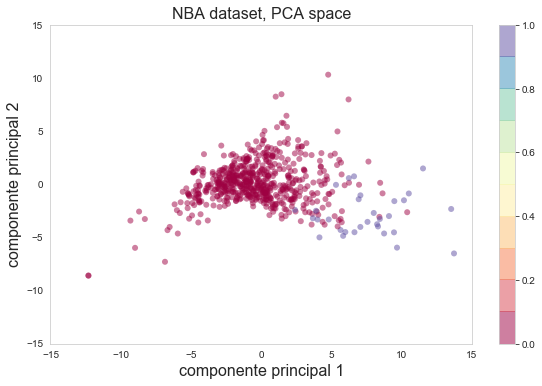

In [35]:
# graficamos componente principal 1 y componente principal 2
pc_x = 0
pc_y = 1

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ['s', 'v', 'o', 'd', 's', 'v', 'o', 'd', 's']

fig = plt.figure(figsize=(8,5))
plt.scatter(X_pca[:, pc_x], X_pca[:, pc_y],
            c=df_result_copy[target_nba], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))

plt.colorbar();
plt.grid(); plt.tight_layout()
plt.title('NBA dataset, PCA space', fontsize=16)
plt.xlabel(pcs_names[pc_x], fontsize=16)
plt.ylabel(pcs_names[pc_y], fontsize=16)
lim = np.abs(plt.axis()).max()
plt.axis([-lim, lim, -lim, lim])
plt.show()

In [36]:
# función que pinta dos componentes principales y además pinta con flechas y nombres las características o 
# atributos originales para ver que peso tienen en cada componente principal pintada.
def PCA_plot(X_std, attribute_names, pca, pcs_names, ax, pc_x=0, pc_y=1, escala_flechas=1):
    X_pca = pca.transform(X_std)

    plt.scatter(X_pca[:, pc_x], X_pca[:, pc_y], s=20,
                c=df_result_copy[target_nba], edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap('Spectral', 10))

    plt.colorbar();
    
    factor = escala_flechas*6*np.sqrt(np.max(np.cov(X_std,rowvar=False)))
    aux = np.eye(len(attribute_names))
    attributes_PCA = pca.transform(aux)
    
    for a,name in zip(attributes_PCA,attribute_names):
        ax.arrow(0, 0, a[pc_x]*factor, a[pc_y]*factor,
                 head_width=1/4*0.05*factor*1.5/escala_flechas,
                 head_length=1/4*0.1*factor*1.5/escala_flechas,
                 fc='k', ec='k')
        plt.text(a[pc_x]*factor, a[pc_y]*factor, name, color='r')
        
    plt.grid(); plt.tight_layout()
    plt.xlabel(pcs_names[pc_x], fontsize=16)
    plt.ylabel(pcs_names[pc_y], fontsize=16)

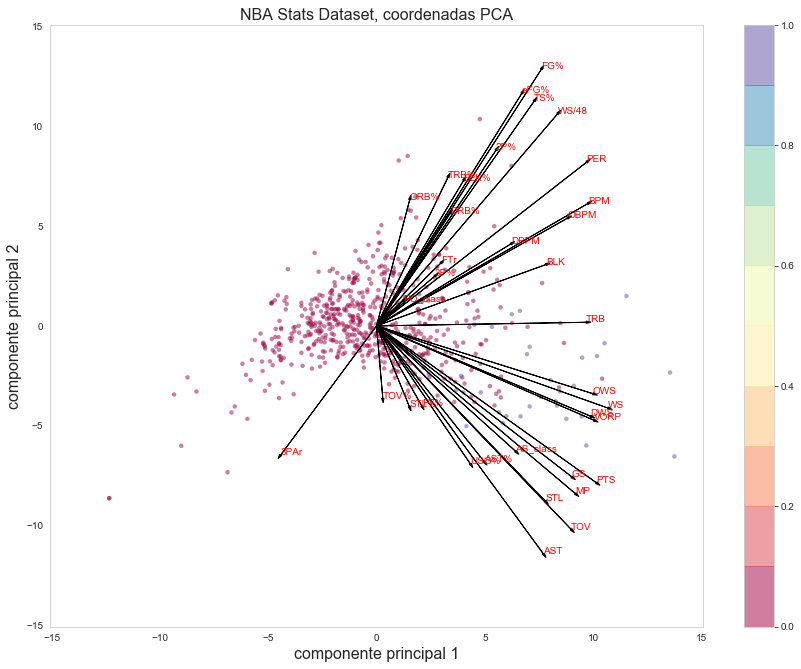

In [37]:
fig = plt.figure(figsize=(12,10))
ax = plt.subplot(1,1,1)

PCA_plot(X_std, nombres_atributos,
         pca, pcs_names, ax, pc_x=0, pc_y=1, escala_flechas=7)
plt.title('NBA Stats Dataset, coordenadas PCA', fontsize=16)
lim = np.abs(plt.axis()).max()
plt.axis([-lim, lim, -lim, lim])
plt.show()

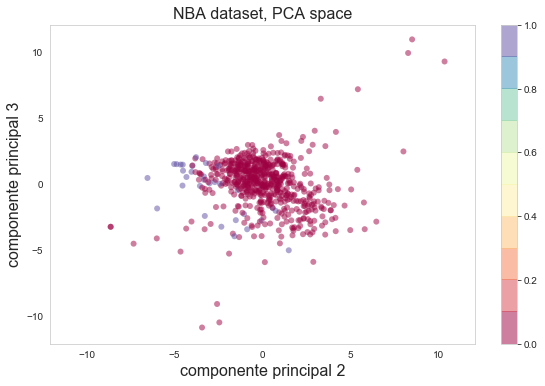

In [38]:
# componente principal 2 y componente principal 3
pc_x = 1
pc_y = 2

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ['s', 'v', 'o', 'd', 's', 'v', 'o', 'd', 's']

fig = plt.figure(figsize=(8,5))
plt.scatter(X_pca[:, pc_x], X_pca[:, pc_y],
            c=df_result_copy[target_nba], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))

plt.colorbar();
plt.grid(); plt.tight_layout()
plt.title('NBA dataset, PCA space', fontsize=16)
plt.xlabel(pcs_names[pc_x], fontsize=16)
plt.ylabel(pcs_names[pc_y], fontsize=16)
lim = np.abs(plt.axis()).max()
plt.axis([-lim, lim, -lim, lim])
plt.show()

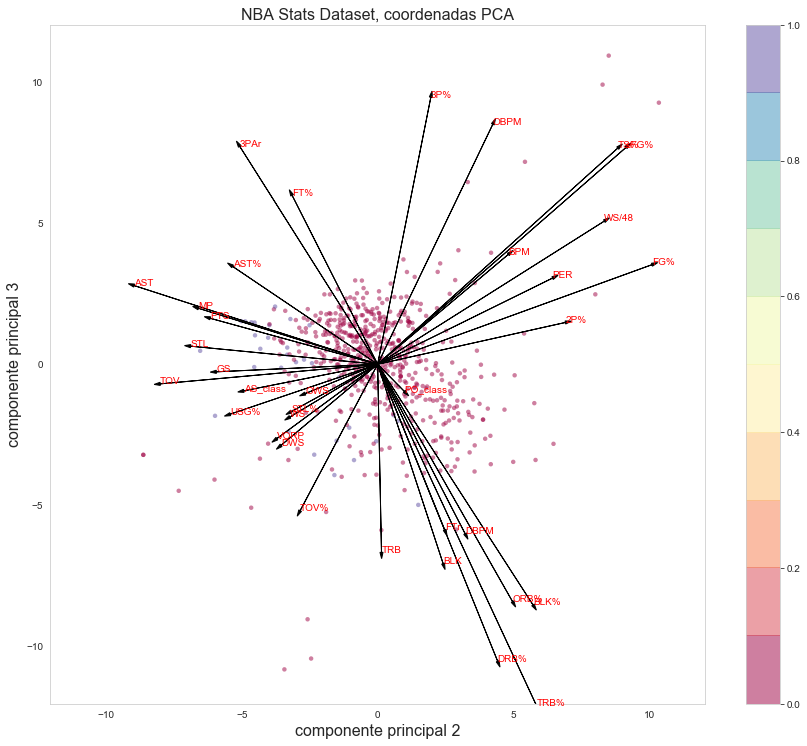

In [39]:
# componente principal 2 y componente principal 3
fig = plt.figure(figsize=(12,10))
ax = plt.subplot(1,1,1)

PCA_plot(X_std, nombres_atributos,
         pca, pcs_names, ax, pc_x=1, pc_y=2, escala_flechas=5.5)
plt.title('NBA Stats Dataset, coordenadas PCA', fontsize=16)
lim = np.abs(plt.axis()).max()
plt.axis([-lim, lim, -lim, lim])
plt.show()

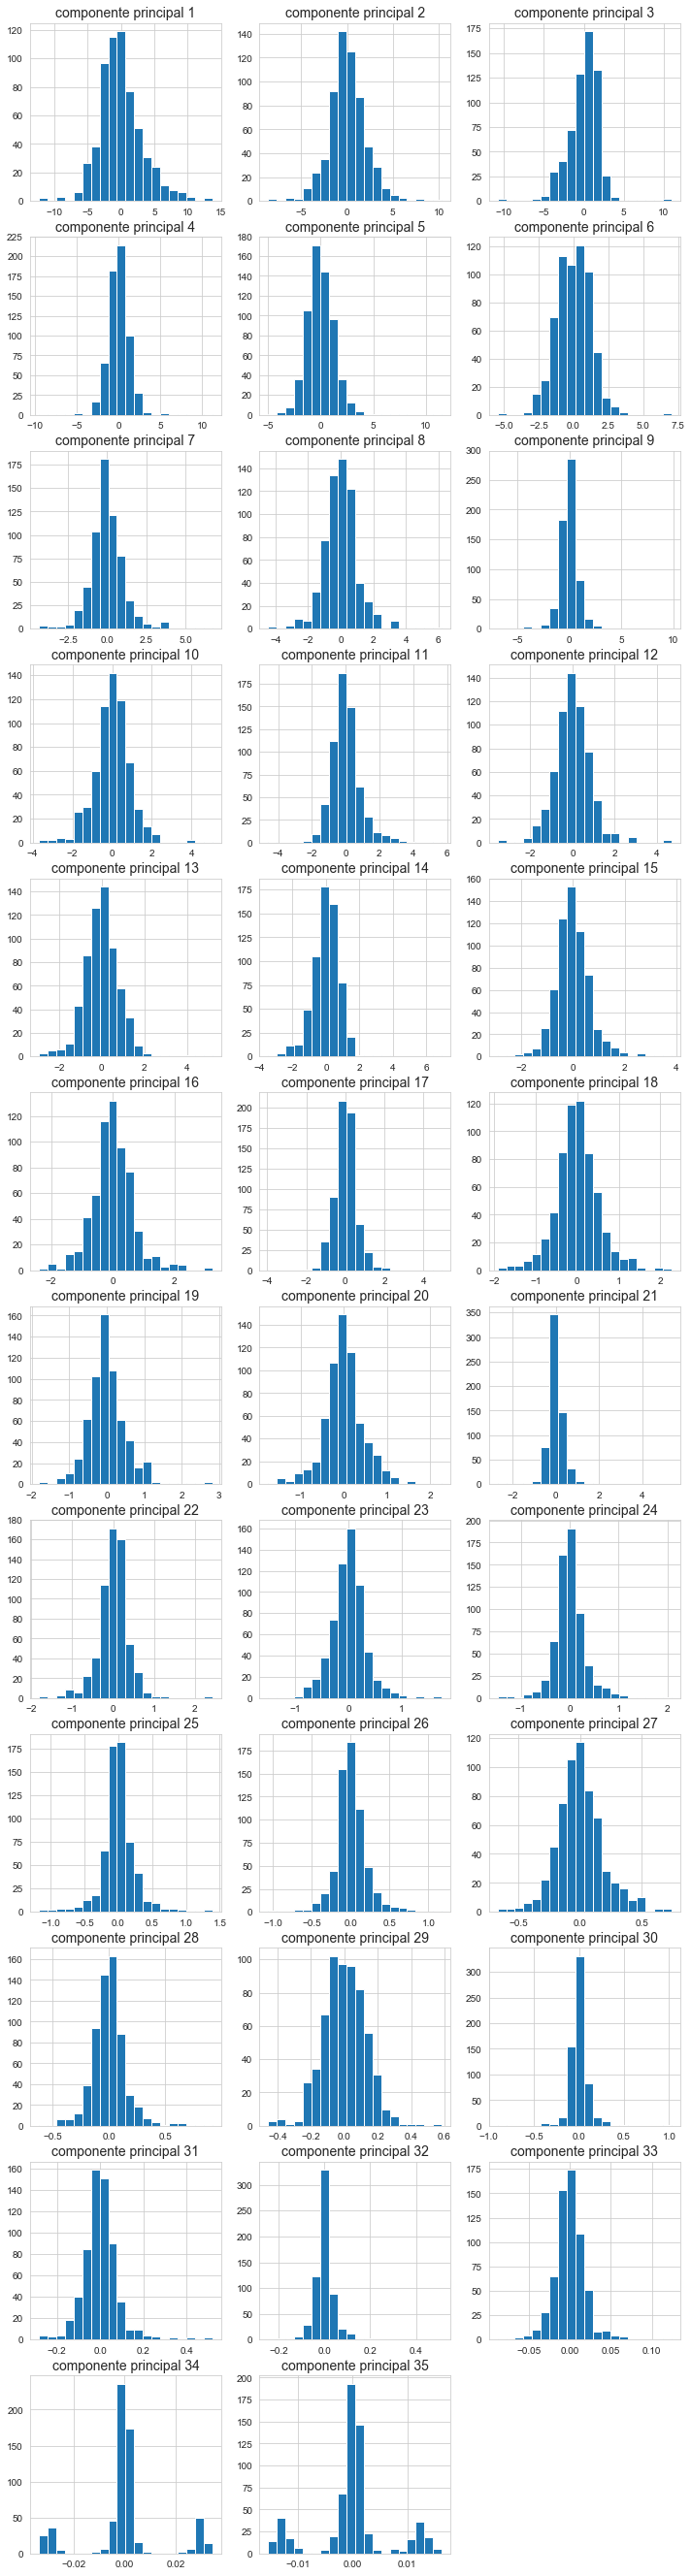

In [40]:
# histogramas de los componentes principales
nrows = int(np.ceil(pca.n_components_/3))
plt.figure(figsize=(12,4*nrows))

for i in range(pca.n_components_):
    plt.subplot(nrows,3,i+1)
    plt.hist(X_pca[:,i], bins=20)
    plt.title(pcs_names[i], fontsize=14)
plt.show()

##### Comentarios
###### PCA
El método de PCA permite “condensar” la información aportada por múltiples variables en solo unas pocas componentes.
      
Se usa la proporción acumulada de varianza para determinar la cantidad total de varianza que explican los componentes principales. Se conservan los componentes principales que explican un nivel aceptable de varianza. El nivel aceptable depende de la aplicación específica. Para propósitos descriptivos, es posible que solo se necesite explicar el 80% de la varianza. Sin embargo, si se desea realizar otros análisis con los datos, se recomienda que los componentes principales expliquen por lo menos el 90% de la varianza.
Con los valores propios de la varianza también se puede determinar el número de componentes principales. Conservar los componentes principales con los valores propios más grandes. Por ejemplo, según el criterio de Kaiser, se usan solo los componentes principales con valores propios que son mayores que 1.      

###### Gráficas Componente principal 1-Componente principal 2, y Componente principal 2 -Componente principal 3
En las gráficas de influencias se muestran visualmente los resultados para los dos pares de componentes, identificando con las flechas y su posición las influencias de cada atributo en relación a los componentes principales del eje x y el eje y de la gráfica.

#### 3. Técnicas de clustering.

**3.1 Seleccionar el número de clusters para K-means**

In [41]:
# dividimos variable target y predictoras.
vars_nba = list(df_result.columns[1:-1])
target_nba = df_result.columns[-1]
print(vars_nba)
print(target_nba)

['GS', 'MP', 'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', '3PAr', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DRB%', 'DWS', 'FTr', 'OBPM', 'ORB%', 'OWS', 'PER', 'STL%', 'TOV%', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48', 'PO_class']
AS_class


In [42]:
# ver el número de registros para cada valor de la clase target
pd.value_counts(df_result['AS_class'])

0    591
1     31
Name: AS_class, dtype: int64

In [43]:
# dataframe con las variables predictoras
df_nba_vars = df_result[vars_nba]
df_nba_vars.head()

,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,...,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,PO_class
0,2,19.0,0.357,0.323,0.500,0.487,0.923,1.5,0.6,0.5,...,6.3,1.3,7.9,4.2,0.507,12.2,-0.2,0.6,0.053,1
1,0,12.3,0.222,0.133,0.667,0.278,0.700,2.5,0.8,0.1,...,2.9,0.4,15.2,11.3,0.379,9.2,-0.1,-0.1,-0.022,0
2,1,12.6,0.345,0.338,0.361,0.459,0.778,1.8,1.9,0.4,...,7.6,1.5,19.7,7.4,0.474,13.5,-0.3,0.1,0.011,0
3,80,33.4,0.595,0.000,0.596,0.595,0.500,9.5,1.6,1.5,...,18.5,2.0,12.6,14.7,0.591,16.4,3.2,9.1,0.163,1
4,28,23.3,0.576,0.200,0.588,0.579,0.735,7.3,2.2,0.9,...,17.9,1.8,17.1,16.6,0.623,15.8,2.4,6.8,0.171,0


In [44]:
# dataframe con la variable target
df_nba_target = df_result[target_nba]
df_nba_target.head()

0    0
1    0
2    0
3    0
4    0
Name: AS_class, dtype: int64

In [45]:
# datos para Kmeans
LOOPS = 20
MAX_ITERATIONS = 30
INITIALIZE_CLUSTERS = 'k-means++'
CONVERGENCE_TOLERANCE = 0.001
NUM_THREADS = 8

x = df_nba_vars
y = df_nba_target

Una primera opción para seleccionar el número de clusters se basa en el cómputo de la inercia de cada uno de los clusters. Se prueba con distintos candidatos de número de cluster y se calcula la inercia global.

Ese inercia no es sino el valor medio de la varianza de cada cluster respecto a su centroide. 

In [46]:
def plot_results(inertials):
    x, y = zip(*[inertia for inertia in inertials])
    plt.plot(x, y, 'ro-', markersize=8, lw=2)
    plt.grid(True)
    plt.xlabel('Num Clusters')
    plt.ylabel('Inertia')
    plt.show()
    
def select_clusters(points, loops, max_iterations, init_cluster, tolerance,
                    num_threads):
    
    inertia_clusters = list()

    for i in range(1, loops + 1, 1):
        # Creamos el objeto Kmeans
        kmeans = KMeans(n_clusters=i, max_iter=max_iterations,
                        init=init_cluster, tol=tolerance, n_jobs=num_threads)

        # Calculamos Kmeans
        kmeans.fit(points)

        # Obtenemos la inercia
        inertia_clusters.append([i, kmeans.inertia_])

    plot_results(inertia_clusters)

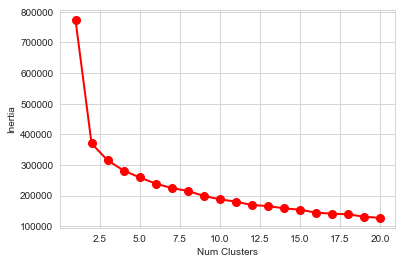

In [47]:
select_clusters(x, LOOPS, MAX_ITERATIONS, INITIALIZE_CLUSTERS, CONVERGENCE_TOLERANCE, NUM_THREADS)

Los dendrogramas también nos pueden ser de ayuda a la hora de determinar posibles candidatos para el número de clusters.

In [48]:
def plot_dendrogram(points):
    # calcula la distancia entre puntos o grupos de puntos
    Z = linkage(points, metric='euclidean', method='ward')

    plt.title('Dendrogram')
    plt.xlabel('Points')
    plt.ylabel('Euclidean Distance')

    # genera el dendograma
    dendrogram(
        Z,
        truncate_mode='lastp',
        p=30,
        leaf_rotation=90.,
        leaf_font_size=12.,
        show_contracted=True
    )

    plt.show()

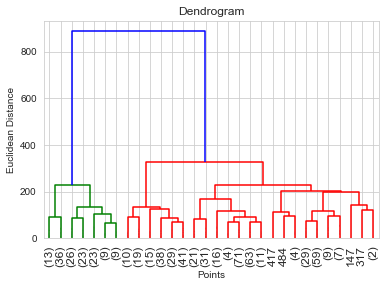

In [49]:
plot_dendrogram(x)

Finalmente, se puede medir la distancia existente entre clusters. Se buscará el valor de cluster que maximiza la distancia inter-cluster.

Aquí nos apoyamos de nuevo en el dendrograma, pues nos permite medir en cada nivel la distancia que existen entre las diversas ramas. En cada uno de los niveles nos quedamos con las últimas 10 distancias.

In [50]:
def plot_gap(points):    
    # Calculamos las distancias entre los puntos
    Z = linkage(points, metric='euclidean', method='ward')

    # Nos quedamos con las últimas 10 distancias. Las distancias están en la columna 2 (tercera columna) de Z
    last = Z[-10:, 2]
    
    num_clusters = np.arange(1, len(last) + 1)

    # Determinados el Gap
    gap = np.diff(last, n=2)  # Computamos la derivada segunda
    plt.plot(num_clusters[:-2] + 1, gap[::-1], 'ro-', markersize=8, lw=2)
    plt.show()

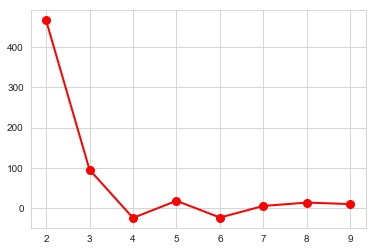

In [51]:
plot_gap(x)

#### Comentarios
Se han utilizado tres técnicas para intentar obtener el número adecuado de clusters: el uso del dendrograma, la técnica de elbow y la técnica gap de distancia máxima entre clusters. Vamos a proceder a analizar los resultados obtenidos en cada una de ellas y comentaremos la interpretación que hemos hecho de cada una de ellas:

   - Dendrograma: A través de esta técnica podemos ver como claramente tenemos dos grupos los cuales están ramificados a través de la agrupación definida con la línea azul.
   
   - Elbow: Para este caso se nos hace más complicado determinar el número de clusters que deberíamos seleccionar. El problema es que a través del gráfico es claro que la diferencia entre el punto 1 y el 2, es máxima, y es en el punto 2 a partir del cual empieza a formarse la curva, pero si nos fijamos en el siguiente punto que está entorno al 3, parace que la distancia entre cada punto es menor. Por lo que podríamos tener la duda en este caso si el número de cluster a definir sería 2 o 3.
   
   - Maximizar la distancia entre clusters: Es gracias a esta técnica con la que tenemos la mayor seguridad que el número de clusters a definir es 2. Se ve claramente como es en el 2 donde la distancia máxima es mayor.

Estas tres técnicas nos sirven para orientarnos en el número de clusters que queremos definir, pero de forma individual no son determinantes. Es por esta razón que haciendo un análisis de los resultados obtenidos en el codo de la curva de inercias, el dendrograma y la técnica de maximizar la distancia entre clusters, consideramos que el número de clusters a definir es de 2. El estudio cojunto de todas las técnicas nos permiten llegar a una mejor conclusión.

In [52]:
# aplicamos KMeans con 2 clusters, para distribuir los datos
kmeans_2 = KMeans(n_clusters=2,init='k-means++',max_iter=MAX_ITERATIONS)
kmeans_2 = kmeans_2.fit(x)

In [53]:
# con el resultado de aplicar kmeans con 2 clusters obtenemos el atributo cluster
nba_stats = kmeans_2.fit_predict(x)

In [54]:
# añadimos el atributo que identifica a cada registro en uno de los clusters
df_result["Cluster"] = nba_stats
df_result.head()

,Player,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,...,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,PO_class,AS_class,Cluster
0,Álex Abrines,2,19.0,0.357,0.323,0.500,0.487,0.923,1.5,0.6,...,7.9,4.2,0.507,12.2,-0.2,0.6,0.053,1,0,0
1,Quincy Acy,0,12.3,0.222,0.133,0.667,0.278,0.700,2.5,0.8,...,15.2,11.3,0.379,9.2,-0.1,-0.1,-0.022,0,0,0
2,Jaylen Adams,1,12.6,0.345,0.338,0.361,0.459,0.778,1.8,1.9,...,19.7,7.4,0.474,13.5,-0.3,0.1,0.011,0,0,0
3,Steven Adams,80,33.4,0.595,0.000,0.596,0.595,0.500,9.5,1.6,...,12.6,14.7,0.591,16.4,3.2,9.1,0.163,1,0,1
4,Bam Adebayo,28,23.3,0.576,0.200,0.588,0.579,0.735,7.3,2.2,...,17.1,16.6,0.623,15.8,2.4,6.8,0.171,0,0,0


/Users/josemanuel/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/josemanuel/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


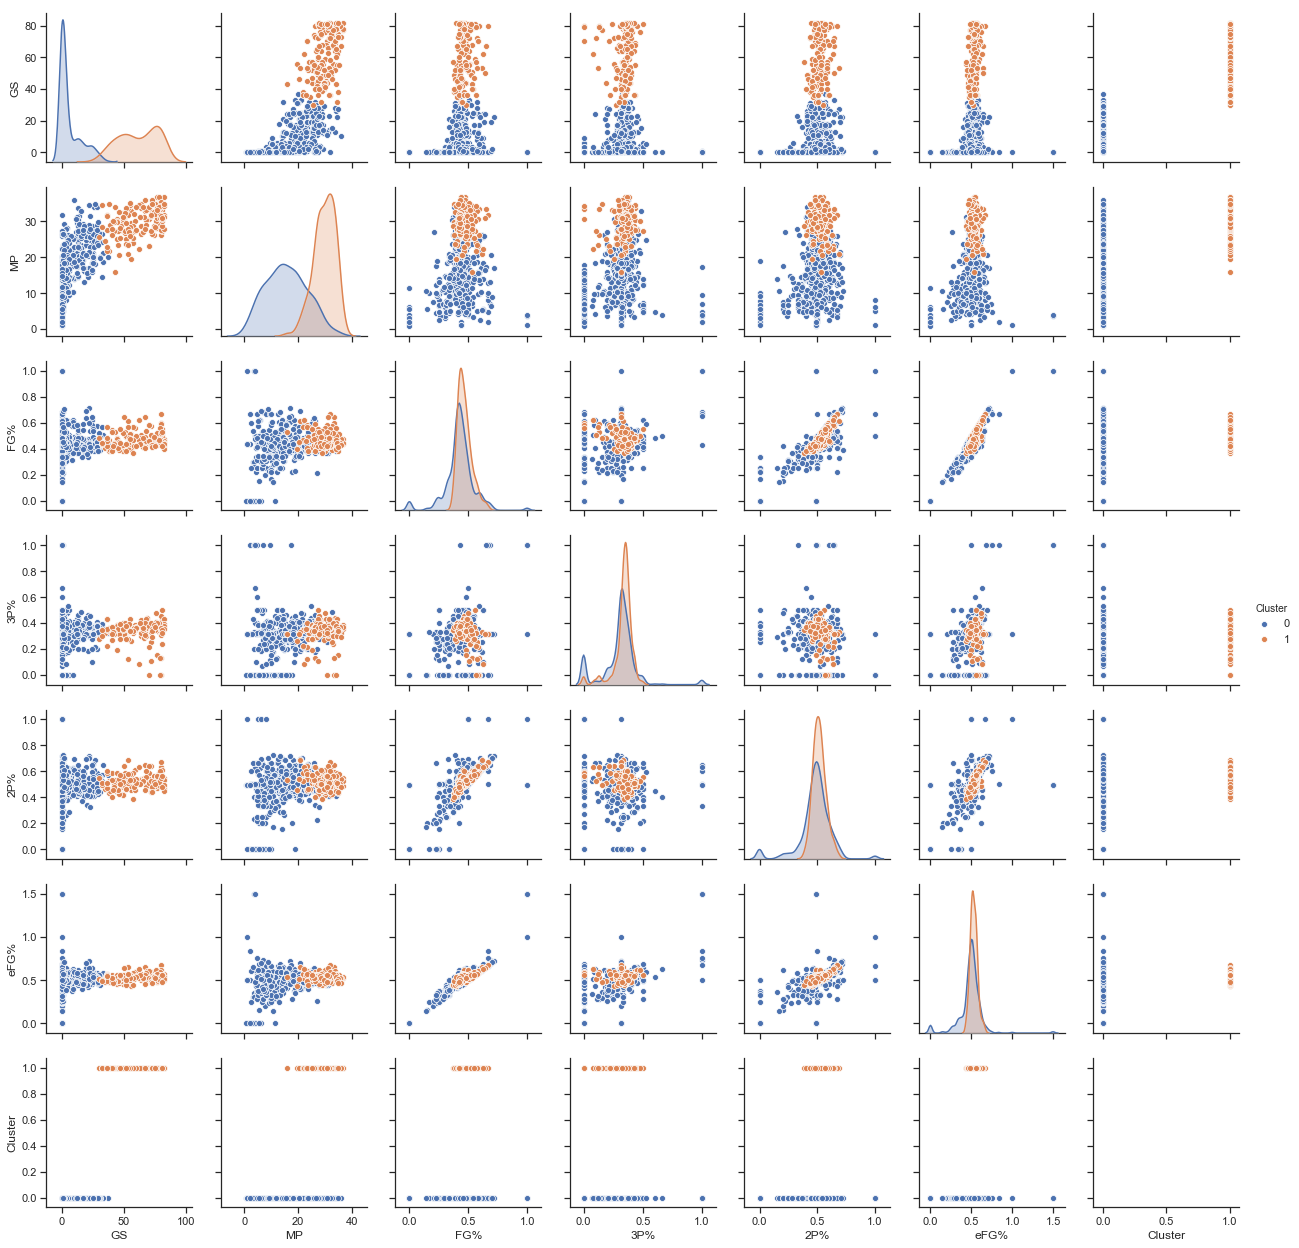

In [55]:
# graficamos los datos del dataset donde se aprecia para cada cluster con un color diferente
# para cada atributo del dataset, se puede apreciar como se agrupan los registros de cada cluster
sns.set(style="ticks")

vars_uno = df_result.columns[ : 7]
vars_dos = df_result.columns[7 : 14]
vars_tres = df_result.columns[14 : 21]
vars_cuatro = df_result.columns[21 : 28]
vars_cinco = df_result.columns[28 : -1]
target_nba = df_result.columns[-1]

sns.pairplot( df_result[ list(vars_uno) + [target_nba] ], hue="Cluster" )

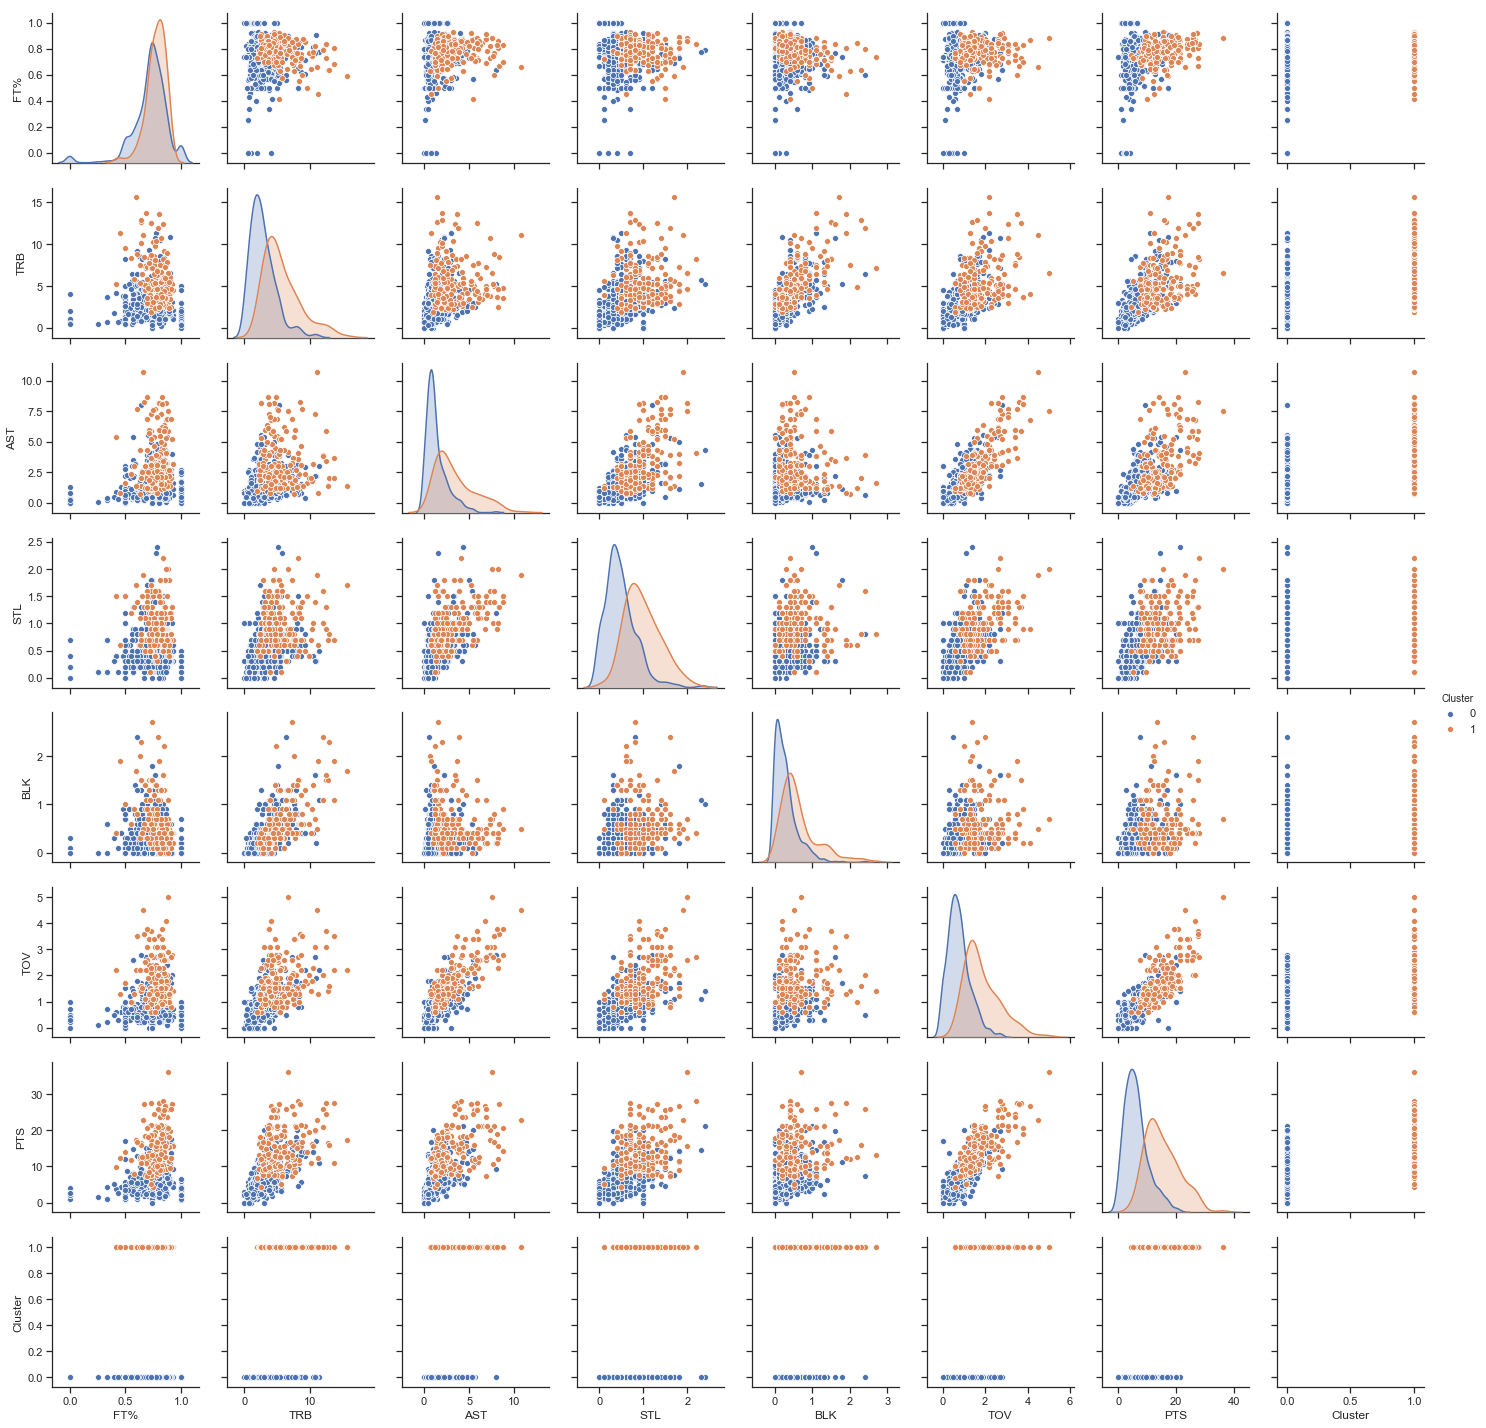

In [56]:
sns.pairplot( df_result[ list(vars_dos) + [target_nba] ], hue="Cluster" )

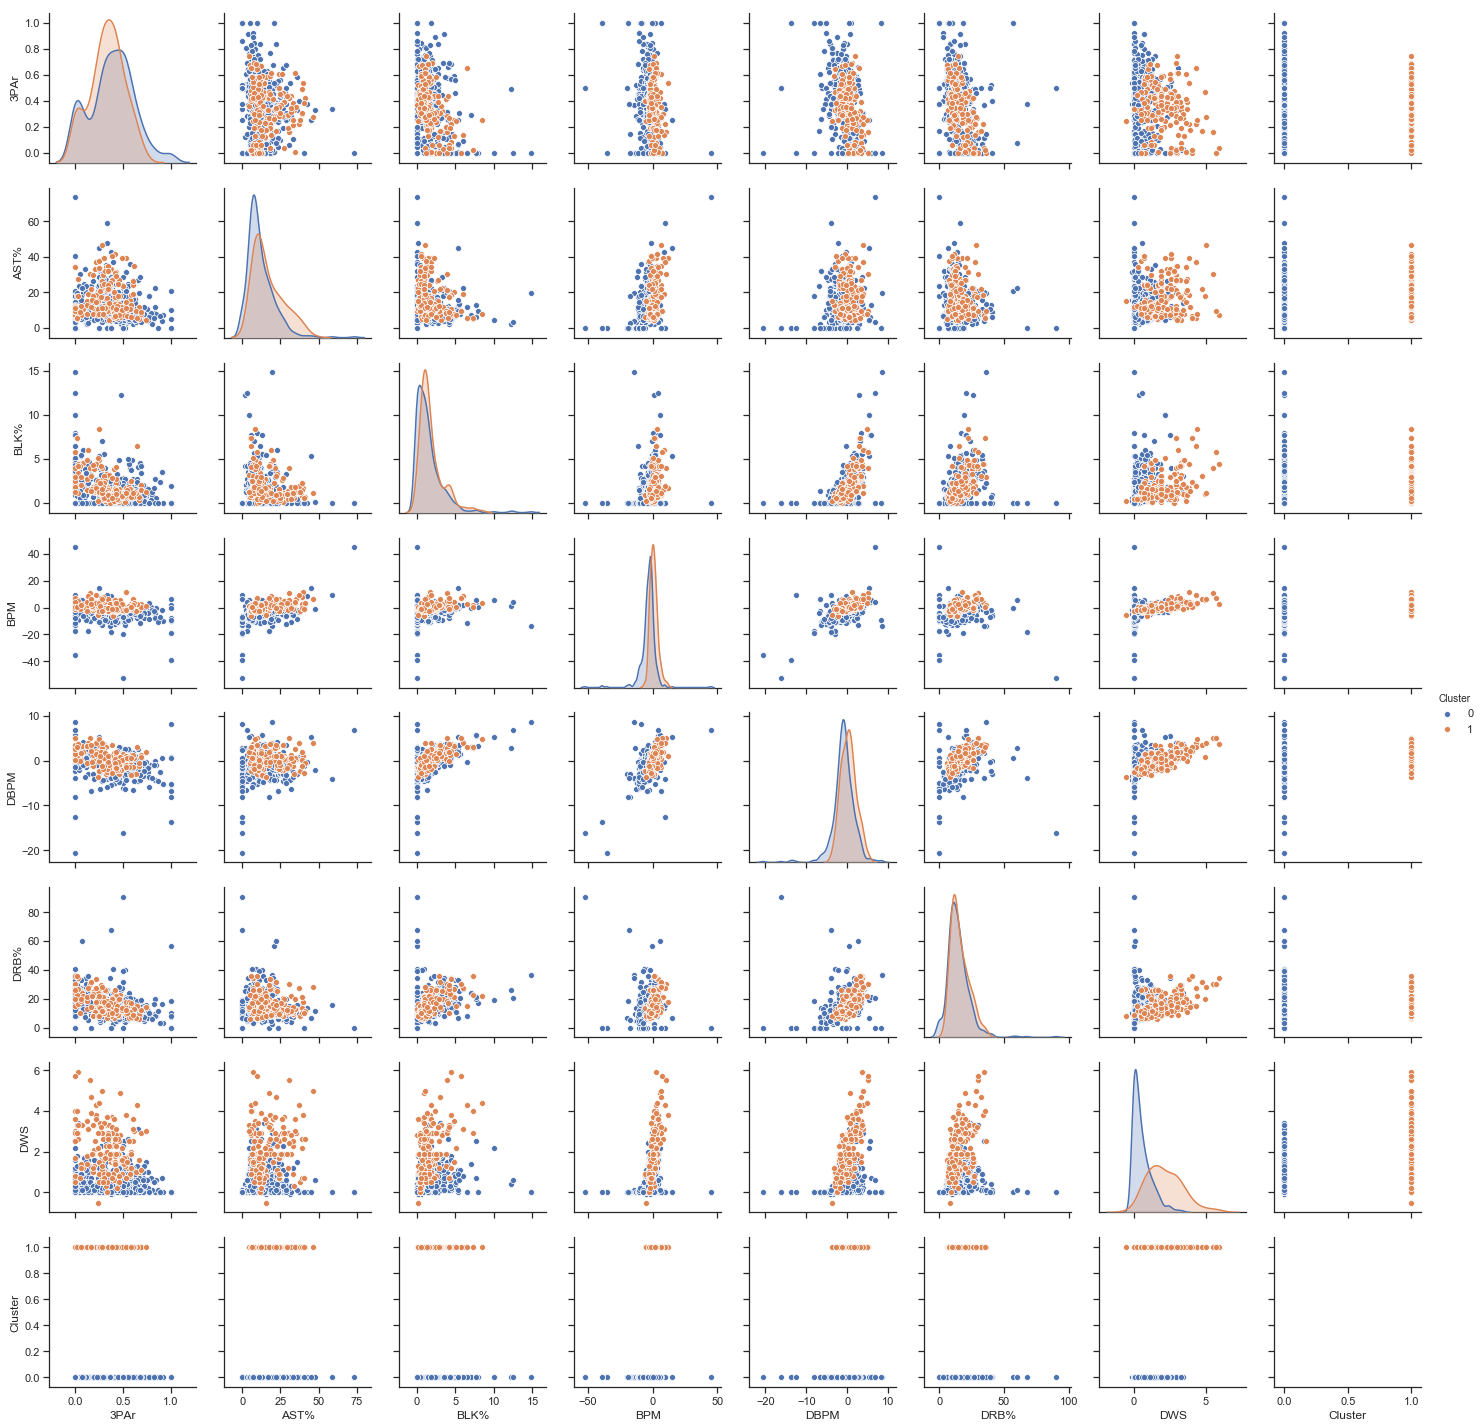

In [57]:
sns.pairplot( df_result[ list(vars_tres) + [target_nba] ], hue="Cluster" )

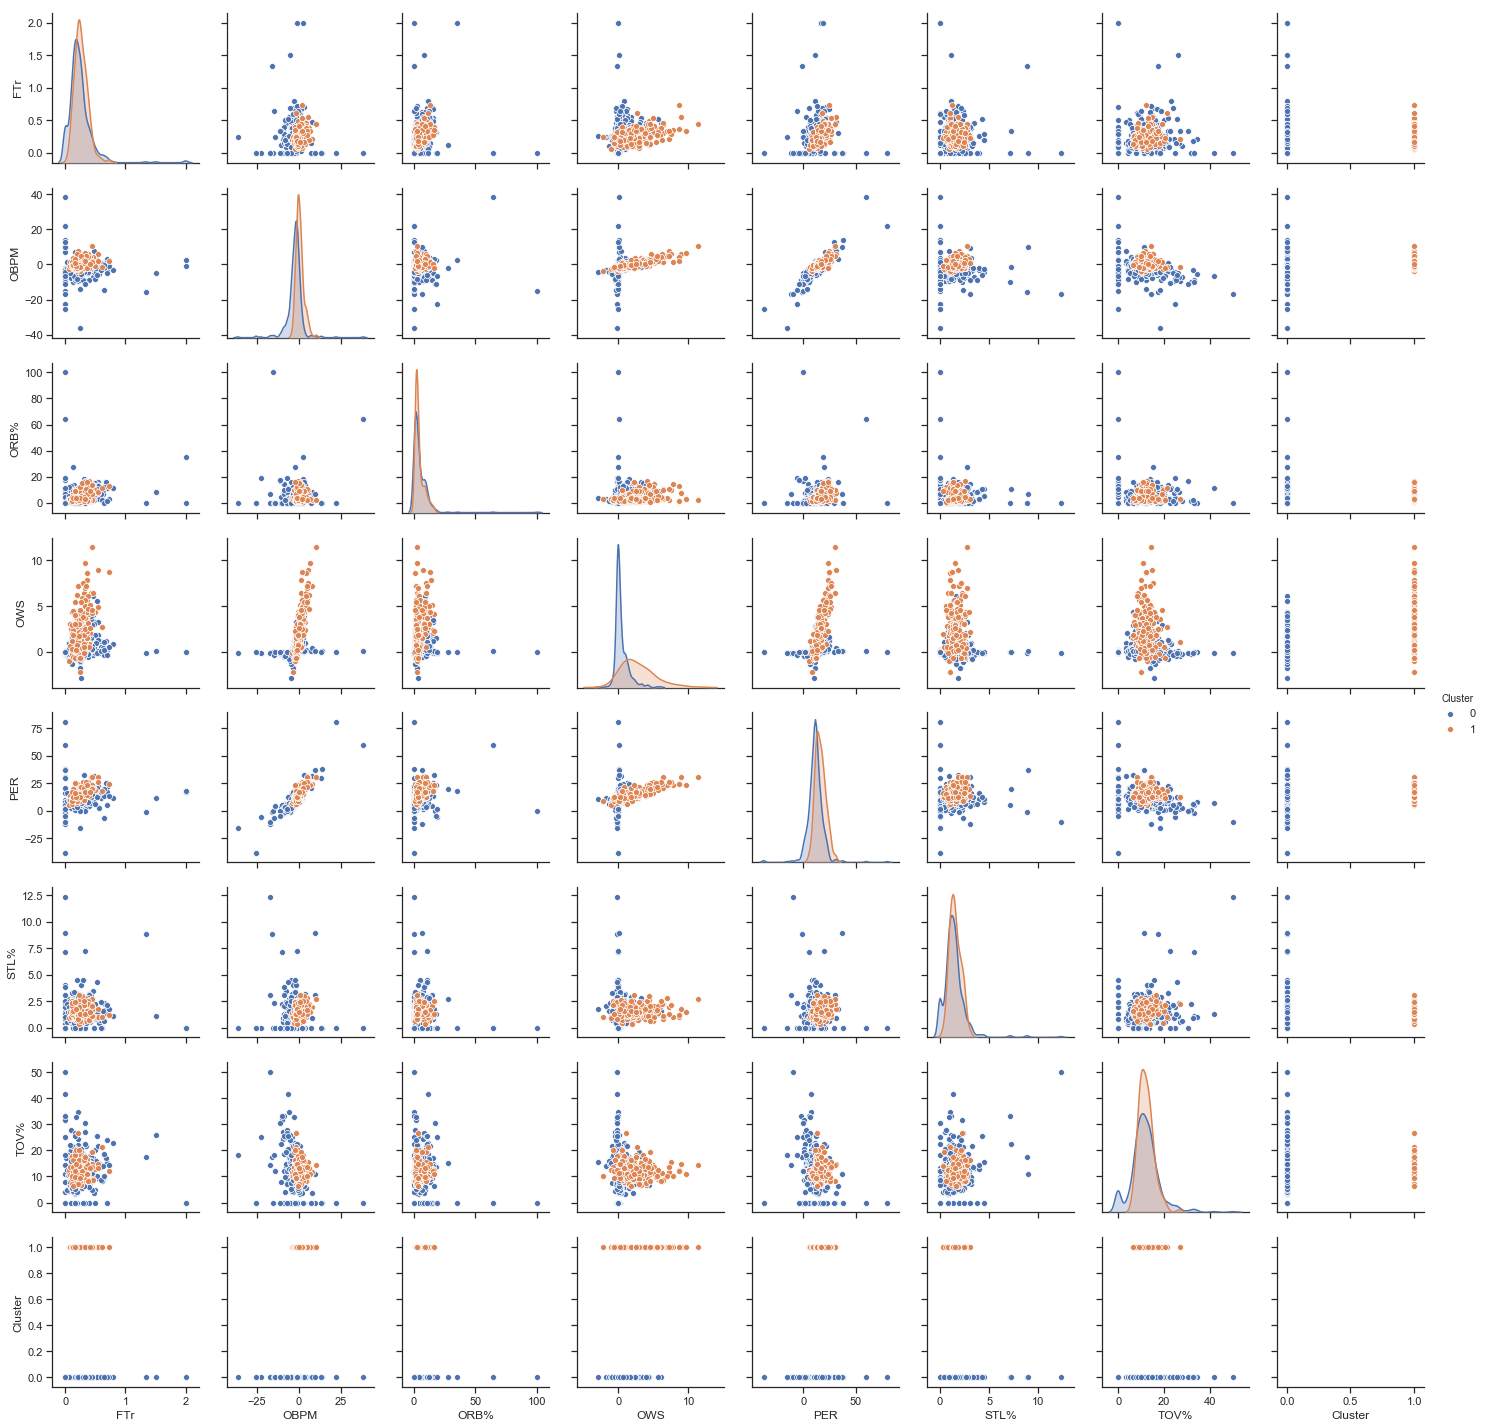

In [58]:
sns.pairplot( df_result[ list(vars_cuatro) + [target_nba] ], hue="Cluster" )

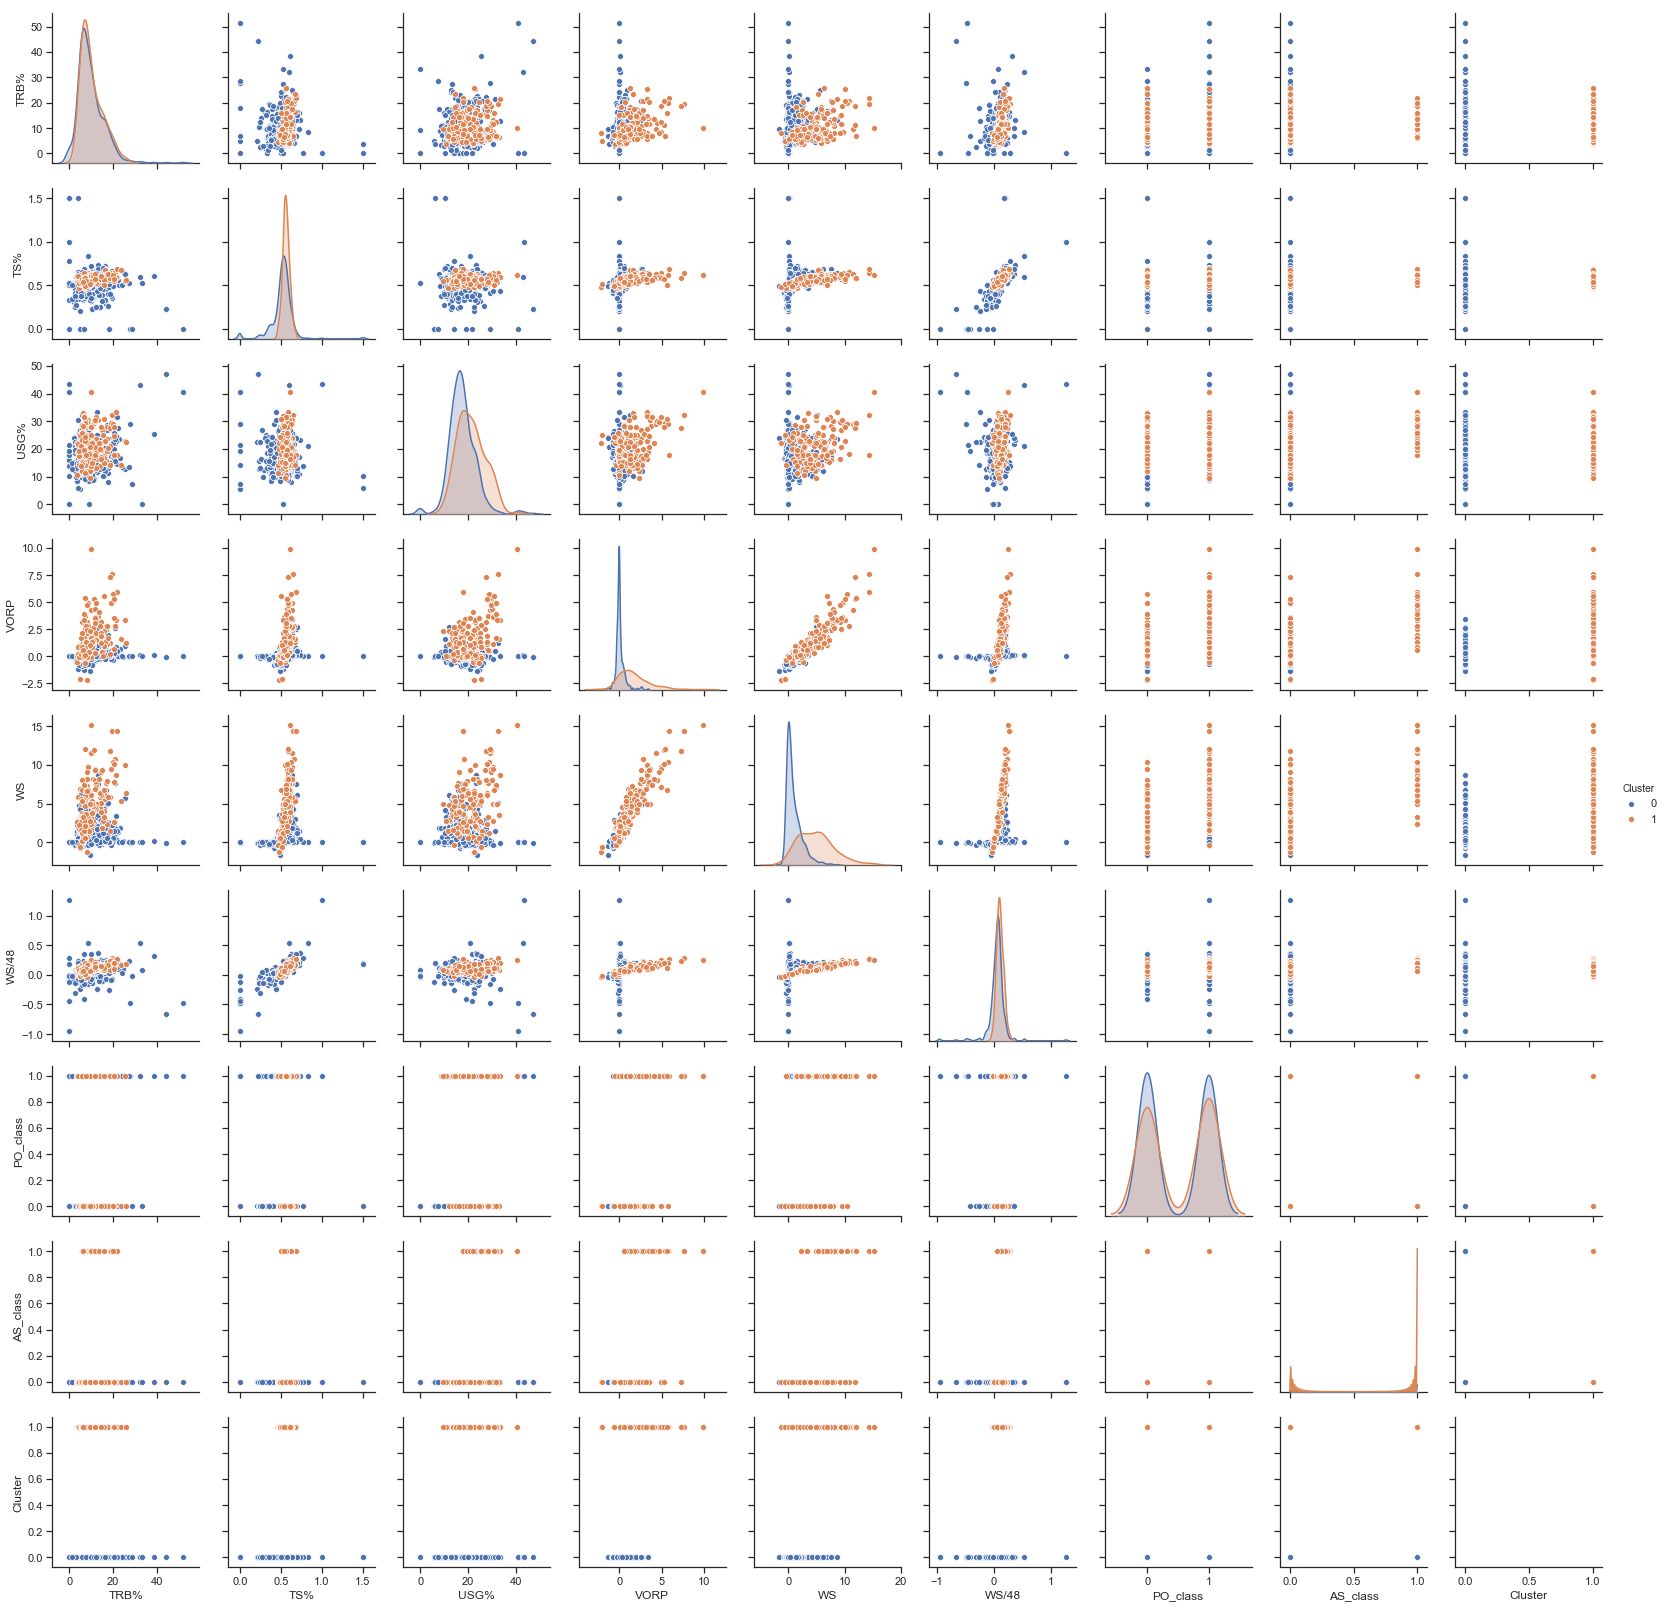

In [59]:
sns.pairplot( df_result[ list(vars_cinco) + [target_nba] ], hue="Cluster" )

In [60]:
# ver los registros de cada cluster
pd.value_counts(df_result['Cluster'])

0    470
1    152
Name: Cluster, dtype: int64

In [61]:
# dataframe con los registros del cluster 0. Describe para primer análisis de estos registros.
df_result_0 = df_result[df_result['Cluster']==0]
df_result_0.describe()

,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,...,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,PO_class,AS_class,Cluster
count,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,...,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.0
mean,6.193617,15.767021,0.427795,0.306438,0.485130,0.490628,0.723739,2.849362,1.357234,0.485532,...,11.846695,9.962553,0.520228,17.688085,0.083191,1.051702,0.058928,0.495745,0.008511,0.0
std,8.794428,7.632488,0.124423,0.149504,0.134845,0.137860,0.154265,1.962840,1.144348,0.354807,...,6.121608,6.080778,0.131814,5.653735,0.518356,1.413349,0.136851,0.500515,0.091958,0.0
min,0.000000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.400000,-1.700000,-0.946000,0.000000,0.000000,0.0
25%,0.000000,10.000000,0.387000,0.278000,0.441500,0.457000,0.667000,1.500000,0.600000,0.300000,...,8.600000,6.025000,0.485000,14.200000,-0.100000,0.025000,0.019250,0.000000,0.000000,0.0
50%,2.000000,15.250000,0.427500,0.324000,0.493410,0.500537,0.736637,2.500000,1.000000,0.400000,...,11.500000,8.750000,0.531534,17.150000,0.000000,0.500000,0.069000,0.000000,0.000000,0.0
75%,10.750000,20.900000,0.480750,0.367750,0.550250,0.547750,0.810000,3.800000,1.800000,0.700000,...,14.500000,12.600000,0.578000,20.400000,0.200000,1.600000,0.112000,1.000000,0.000000,0.0
max,37.000000,36.100000,1.000000,1.000000,1.000000,1.500000,1.000000,11.400000,8.000000,2.400000,...,50.000000,51.600000,1.500000,47.200000,3.400000,8.700000,1.261000,1.000000,1.000000,0.0


In [62]:
# dataframe con los registros del cluster 1. Describe para primer análisis de estos registros.
df_result_1 = df_result[df_result['Cluster']==1]
df_result_1.describe()

,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,...,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,PO_class,AS_class,Cluster
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.00000,152.000000,152.000000,152.000000,...,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.0
mean,61.769737,29.899342,0.470145,0.336639,0.519013,0.531178,0.77652,5.753289,3.435526,0.990132,...,12.232895,10.362500,0.566493,21.405263,1.717105,4.954605,0.112868,0.519737,0.177632,1.0
std,15.281669,3.949994,0.059028,0.080491,0.055539,0.043165,0.08886,2.806684,2.157918,0.403094,...,3.238219,4.925563,0.041299,5.688641,1.824149,3.167066,0.058987,0.501262,0.383466,0.0
min,30.000000,16.000000,0.370000,0.000000,0.387000,0.436000,0.41700,1.900000,0.700000,0.100000,...,6.400000,3.800000,0.464000,9.500000,-2.200000,-1.300000,-0.030000,0.000000,0.000000,1.0
25%,49.000000,27.400000,0.428750,0.323750,0.482000,0.501750,0.72875,3.700000,1.800000,0.700000,...,10.000000,6.700000,0.538750,17.275000,0.400000,2.550000,0.069250,0.000000,0.000000,1.0
50%,64.000000,30.300000,0.458500,0.350000,0.514000,0.526000,0.78800,5.000000,2.700000,0.900000,...,11.850000,8.600000,0.566000,20.850000,1.300000,5.000000,0.106000,1.000000,0.000000,1.0
75%,77.000000,33.100000,0.497750,0.375000,0.549500,0.557000,0.83900,7.300000,4.550000,1.225000,...,14.000000,13.750000,0.591000,25.100000,2.525000,6.700000,0.150250,1.000000,0.000000,1.0
max,82.000000,36.900000,0.669000,0.500000,0.685000,0.669000,0.92800,15.600000,10.700000,2.200000,...,26.800000,25.900000,0.682000,40.500000,9.900000,15.200000,0.292000,1.000000,1.000000,1.0


In [63]:
# hacemos otra copia del dataframe original y vamos a volver a aplicar KMeans pero con los datos normalizados
df_result_copy_2 = df_result.copy()
df_result_copy_2 = df_result_copy_2.drop(columns=['Player'], axis=1)

In [64]:
# normalizar los datos
df_normalizado = (df_result_copy_2 - df_result_copy_2.mean()) / df_result_copy_2.std()

df_nba_vars_n = df_normalizado[vars_nba]
df_nba_target_n = df_normalizado[target_nba]

LOOPS = 20
MAX_ITERATIONS = 30
INITIALIZE_CLUSTERS = 'k-means++'
CONVERGENCE_TOLERANCE = 0.001
NUM_THREADS = 8

x_n = df_nba_vars_n
y_n = df_nba_target_n

In [65]:
kmeans_2_n = KMeans(n_clusters=2,init='k-means++',max_iter=MAX_ITERATIONS)
kmeans_2_n = kmeans_2_n.fit(x_n)

In [66]:
nba_n = kmeans_2_n.fit_predict(x_n)

In [67]:
# añadimos el atributo que identifica a cada registro en uno de los clusters
df_nba_n = df_result
df_nba_n["Cluster"] = nba_n
df_nba_n.head()

,Player,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,...,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,PO_class,AS_class,Cluster
0,Álex Abrines,2,19.0,0.357,0.323,0.500,0.487,0.923,1.5,0.6,...,7.9,4.2,0.507,12.2,-0.2,0.6,0.053,1,0,0
1,Quincy Acy,0,12.3,0.222,0.133,0.667,0.278,0.700,2.5,0.8,...,15.2,11.3,0.379,9.2,-0.1,-0.1,-0.022,0,0,0
2,Jaylen Adams,1,12.6,0.345,0.338,0.361,0.459,0.778,1.8,1.9,...,19.7,7.4,0.474,13.5,-0.3,0.1,0.011,0,0,0
3,Steven Adams,80,33.4,0.595,0.000,0.596,0.595,0.500,9.5,1.6,...,12.6,14.7,0.591,16.4,3.2,9.1,0.163,1,0,1
4,Bam Adebayo,28,23.3,0.576,0.200,0.588,0.579,0.735,7.3,2.2,...,17.1,16.6,0.623,15.8,2.4,6.8,0.171,0,0,1


In [68]:
# ver los registros de cada cluster
pd.value_counts(df_nba_n['Cluster'])

0    440
1    182
Name: Cluster, dtype: int64

In [69]:
# dataframe con los registros del cluster 0. Describe para primer análisis de estos registros.
df_nba_0_n = df_nba_n[df_nba_n['Cluster']==0]
df_nba_0_n.describe()

,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,...,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,PO_class,AS_class,Cluster
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,...,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.0,440.0
mean,8.195455,15.482955,0.413520,0.306301,0.473030,0.480530,0.725210,2.489773,1.275682,0.460000,...,11.826015,9.252273,0.509916,17.251818,-0.035682,0.814545,0.042882,0.484091,0.0,0.0
std,13.983980,7.537868,0.116327,0.146911,0.131755,0.136061,0.157581,1.447694,1.004443,0.313028,...,6.190610,5.768246,0.129805,5.264494,0.352246,1.018471,0.120408,0.500316,0.0,0.0
min,0.000000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-2.200000,-1.700000,-0.946000,0.000000,0.0,0.0
25%,0.000000,9.775000,0.381000,0.278000,0.434750,0.451750,0.667000,1.500000,0.600000,0.300000,...,8.600000,5.700000,0.482000,14.100000,-0.200000,0.000000,0.012000,0.000000,0.0,0.0
50%,1.500000,14.750000,0.419000,0.325000,0.489000,0.500000,0.736637,2.300000,1.000000,0.400000,...,11.450000,7.900000,0.526500,16.800000,0.000000,0.500000,0.059000,0.000000,0.0,0.0
75%,11.250000,20.500000,0.463000,0.368000,0.533250,0.535250,0.813000,3.400000,1.800000,0.600000,...,14.325000,11.425000,0.564250,19.600000,0.100000,1.400000,0.094000,1.000000,0.0,0.0
max,81.000000,34.000000,1.000000,1.000000,1.000000,1.500000,1.000000,8.600000,5.600000,1.700000,...,50.000000,51.600000,1.500000,47.200000,1.300000,4.500000,0.537000,1.000000,0.0,0.0


In [70]:
# dataframe con los registros del cluster 1. Describe para primer análisis de estos registros.
df_nba_1_n = df_nba_n[df_nba_n['Cluster']==1]
df_nba_1_n.describe()

,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,...,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,PO_class,AS_class,Cluster
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,...,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.0
mean,47.769231,28.256593,0.497676,0.331992,0.542681,0.548907,0.764263,6.143956,3.290110,0.968681,...,12.219231,12.013736,0.583797,21.847253,1.735165,4.884615,0.142769,0.543956,0.170330,1.0
std,27.693698,6.068671,0.079375,0.105276,0.069735,0.060147,0.093307,2.706416,2.164585,0.449010,...,3.589336,5.479755,0.055259,6.029034,1.623200,2.985117,0.104959,0.499438,0.376959,0.0
min,0.000000,1.000000,0.383000,0.000000,0.412000,0.448000,0.417000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.468000,9.500000,-0.600000,0.000000,0.012000,0.000000,0.000000,1.0
25%,22.000000,25.825000,0.438500,0.313818,0.495250,0.512000,0.715250,4.200000,1.500000,0.700000,...,10.100000,7.625000,0.553250,17.500000,0.600000,2.600000,0.097750,0.000000,0.000000,1.0
50%,53.500000,29.000000,0.479500,0.345500,0.531500,0.542500,0.773000,5.450000,2.700000,0.900000,...,11.800000,10.450000,0.578500,22.000000,1.300000,4.850000,0.125000,1.000000,0.000000,1.0
75%,73.000000,32.800000,0.535750,0.371750,0.585250,0.574250,0.832000,7.675000,4.300000,1.200000,...,14.275000,15.775000,0.608750,25.100000,2.475000,6.575000,0.173000,1.000000,0.000000,1.0
max,82.000000,36.900000,1.000000,1.000000,1.000000,1.000000,0.928000,15.600000,10.700000,2.400000,...,26.800000,32.000000,1.000000,43.400000,9.900000,15.200000,1.261000,1.000000,1.000000,1.0


In [71]:
# agrupamos datos por Cluster para analizar la media de cada atributo por cluster
df_group = df_nba_n.groupby(['Cluster']).mean()
df_group

,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,...,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,PO_class,AS_class
Cluster,,,,,,,,,,,,,,,,,,,,,
0,8.195455,15.482955,0.413520,0.306301,0.473030,0.480530,0.725210,2.489773,1.275682,0.460000,...,1.416364,11.826015,9.252273,0.509916,17.251818,-0.035682,0.814545,0.042882,0.484091,0.00000
1,47.769231,28.256593,0.497676,0.331992,0.542681,0.548907,0.764263,6.143956,3.290110,0.968681,...,1.634615,12.219231,12.013736,0.583797,21.847253,1.735165,4.884615,0.142769,0.543956,0.17033


#### Comentarios
No se aprecia gran diferencia en la separación de los datos por cluster al normalizar o no.

Al agrupar por cluster como vemos en la celda anterior, es donde puede apreciarse más rápidamente la diferencia de cada atributo según el cluster. Todas las estadísticas se aprecia una mejoría en el cluster 1, que sería aquel de los jugadores con estadísticas válidas para estar en algún quinteto o premio de la temporada.

Vamos a probar KMeans con 3 como número de clusters, y ver como distribuye los datos.

In [94]:
kmeans_3_n = KMeans(n_clusters=3,init='k-means++',max_iter=MAX_ITERATIONS)
kmeans_3_n = kmeans_3_n.fit(x_n)

In [95]:
nba_n = kmeans_3_n.fit_predict(x_n)

In [96]:
# añadimos el atributo que identifica a cada registro en uno de los clusters
df_nba_n = df_result
df_nba_n["Cluster"] = nba_n
df_nba_n.head()

,Player,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,...,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,PO_class,AS_class,Cluster
0,Álex Abrines,2,19.0,0.357,0.323,0.500,0.487,0.923,1.5,0.6,...,7.9,4.2,0.507,12.2,-0.2,0.6,0.053,1,0,1
1,Quincy Acy,0,12.3,0.222,0.133,0.667,0.278,0.700,2.5,0.8,...,15.2,11.3,0.379,9.2,-0.1,-0.1,-0.022,0,0,0
2,Jaylen Adams,1,12.6,0.345,0.338,0.361,0.459,0.778,1.8,1.9,...,19.7,7.4,0.474,13.5,-0.3,0.1,0.011,0,0,1
3,Steven Adams,80,33.4,0.595,0.000,0.596,0.595,0.500,9.5,1.6,...,12.6,14.7,0.591,16.4,3.2,9.1,0.163,1,0,2
4,Bam Adebayo,28,23.3,0.576,0.200,0.588,0.579,0.735,7.3,2.2,...,17.1,16.6,0.623,15.8,2.4,6.8,0.171,0,0,2


In [97]:
# ver los registros de cada cluster
pd.value_counts(df_nba_n['Cluster'])

1    392
2    142
0     88
Name: Cluster, dtype: int64

In [98]:
# dataframe con los registros del cluster 0. Describe para primer análisis de estos registros.
df_nba_0_n = df_nba_n[df_nba_n['Cluster']==0]
df_nba_0_n.describe()

,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,...,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,PO_class,AS_class,Cluster
count,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,...,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.0,88.0
mean,0.352273,7.907955,0.266737,0.209905,0.336333,0.313514,0.680544,1.201136,0.625000,0.214773,...,13.119846,9.426136,0.352366,17.195455,-0.118182,-0.073864,-0.093182,0.511364,0.0,0.0
std,1.083203,4.627981,0.125764,0.139520,0.180044,0.147140,0.225637,0.842205,0.584719,0.231705,...,9.622408,8.824528,0.141858,8.772644,0.124610,0.103384,0.184697,0.502735,0.0,0.0
min,0.000000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.700000,-0.300000,-0.946000,0.000000,0.0,0.0
25%,0.000000,4.700000,0.231000,0.091750,0.246250,0.277500,0.600000,0.600000,0.175000,0.000000,...,7.775000,4.650000,0.328000,12.625000,-0.200000,-0.100000,-0.110750,0.000000,0.0,0.0
50%,0.000000,7.450000,0.302500,0.244000,0.380000,0.346000,0.736637,1.000000,0.500000,0.200000,...,12.120536,6.900000,0.376500,16.350000,-0.100000,0.000000,-0.044000,1.000000,0.0,0.0
75%,0.000000,10.275000,0.333000,0.313818,0.493410,0.402500,0.753750,1.625000,0.925000,0.300000,...,18.125000,11.150000,0.443750,21.625000,0.000000,0.000000,-0.007500,1.000000,0.0,0.0
max,8.000000,27.000000,0.500000,0.500000,0.667000,0.500537,1.000000,3.300000,2.500000,1.000000,...,50.000000,51.600000,0.532000,47.200000,0.000000,0.100000,0.238000,1.000000,0.0,0.0


In [99]:
# dataframe con los registros del cluster 1. Describe para primer análisis de estos registros.
df_nba_1_n = df_nba_n[df_nba_n['Cluster']==1]
df_nba_1_n.describe()

,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,...,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,PO_class,AS_class,Cluster
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,...,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.0,392.0
mean,11.086735,18.162245,0.455673,0.332960,0.511834,0.526092,0.739795,3.031378,1.518622,0.555867,...,11.440051,9.382908,0.553543,17.668112,0.028061,1.137500,0.083883,0.469388,0.0,1.0
std,15.458802,7.371095,0.084746,0.139069,0.090974,0.095552,0.129581,1.629746,1.090102,0.338292,...,4.826605,4.812775,0.091644,4.310165,0.415466,1.110585,0.087948,0.499700,0.0,0.0
min,0.000000,1.000000,0.331000,0.000000,0.200000,0.363000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.398000,6.100000,-2.200000,-1.700000,-0.119000,0.000000,0.0,1.0
25%,0.000000,13.000000,0.407000,0.311000,0.457000,0.479000,0.685000,1.900000,0.775000,0.300000,...,8.700000,6.000000,0.510750,14.900000,-0.100000,0.300000,0.044000,0.000000,0.0,1.0
50%,3.000000,17.850000,0.436500,0.336000,0.500000,0.513000,0.750000,2.800000,1.200000,0.500000,...,11.100000,8.150000,0.544000,17.300000,0.000000,0.900000,0.074500,0.000000,0.0,1.0
75%,16.250000,23.500000,0.482000,0.375000,0.552250,0.551250,0.818000,3.900000,2.100000,0.700000,...,14.000000,11.900000,0.578250,20.100000,0.200000,1.800000,0.107750,1.000000,0.0,1.0
max,81.000000,35.000000,1.000000,1.000000,1.000000,1.500000,1.000000,10.900000,6.000000,1.800000,...,41.700000,38.400000,1.500000,43.400000,1.600000,6.200000,1.261000,1.000000,0.0,1.0


In [100]:
# dataframe con los registros del cluster 2. Describe para primer análisis de estos registros.
df_nba_2_n = df_nba_n[df_nba_n['Cluster']==2]
df_nba_2_n.describe()

,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,...,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,PO_class,AS_class,Cluster
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,...,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.0
mean,55.795775,29.152817,0.495979,0.325375,0.539894,0.545894,0.762681,6.476761,3.590141,0.999296,...,12.593662,12.323239,0.581810,22.027465,2.109155,5.690141,0.142042,0.584507,0.218310,2.0
std,24.656085,5.191355,0.066717,0.092156,0.057003,0.046440,0.096077,2.738604,2.250431,0.437513,...,3.503336,5.489844,0.041594,6.144526,1.636936,2.810929,0.059423,0.494551,0.414561,0.0
min,0.000000,2.500000,0.396000,0.000000,0.421000,0.458000,0.417000,1.500000,0.500000,0.000000,...,0.000000,4.100000,0.473000,9.500000,-0.300000,0.100000,0.047000,0.000000,0.000000,2.0
25%,42.500000,26.350000,0.442000,0.313205,0.499000,0.512500,0.712250,4.600000,1.800000,0.700000,...,10.300000,7.825000,0.554000,17.200000,1.000000,3.700000,0.104250,0.000000,0.000000,2.0
50%,64.000000,30.150000,0.479500,0.343500,0.530000,0.540500,0.773000,5.800000,3.100000,0.900000,...,12.300000,11.200000,0.580000,22.100000,1.700000,5.450000,0.129500,1.000000,0.000000,2.0
75%,77.000000,33.175000,0.534500,0.371750,0.582000,0.571750,0.832000,7.875000,5.200000,1.300000,...,14.475000,15.875000,0.608000,25.825000,2.800000,6.900000,0.175750,1.000000,0.000000,2.0
max,82.000000,36.900000,0.694000,0.529000,0.699000,0.694000,0.928000,15.600000,10.700000,2.400000,...,26.800000,32.000000,0.692000,43.100000,9.900000,15.200000,0.534000,1.000000,1.000000,2.0


In [101]:
# agrupamos datos por Cluster para analizar la media de cada atributo por cluster
df_group = df_nba_n.groupby(['Cluster']).mean()
df_group

,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,STL,...,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,PO_class,AS_class
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.352273,7.907955,0.266737,0.209905,0.336333,0.313514,0.680544,1.201136,0.625000,0.214773,...,1.312500,13.119846,9.426136,0.352366,17.195455,-0.118182,-0.073864,-0.093182,0.511364,0.00000
1,11.086735,18.162245,0.455673,0.332960,0.511834,0.526092,0.739795,3.031378,1.518622,0.555867,...,1.467092,11.440051,9.382908,0.553543,17.668112,0.028061,1.137500,0.083883,0.469388,0.00000
2,55.795775,29.152817,0.495979,0.325375,0.539894,0.545894,0.762681,6.476761,3.590141,0.999296,...,1.620423,12.593662,12.323239,0.581810,22.027465,2.109155,5.690141,0.142042,0.584507,0.21831


Dividiendo en 3 clusters los datos, podemos apreciar como según las medias de cada atributo o estadísticas, más o menos el algoritmo va a separar a los jugadores en 3 grupos:
- Grupo '2': titulares.
- Grupo '1': suplentes que juegan más minutos.
- Grupo '0': jugadores que juegan poco.

A lo mejor jugando con un número mayor de clusters, aunque no sea lo más eficiente según los métodos vistos, puedan distribuirse los jugadores en grupos con mayor sentido.

Ahora vamos a ver el score que arroja KMeans según el número de clusters, usando el método 'silhouette_score'.

In [102]:
# cálculo de componentes principales con PCA para los datos
pca = PCA(n_components = 2)
pca.fit(X)

data = pca.transform(X)

data = pd.DataFrame(data, columns = ['Dimension 1', 'Dimension 2'])

In [103]:
# calcular el score con distinto número de clusters para ver el número óptimo de los mismos.
def KMeans_score(x_kmeans, n = None):
    clusterer = KMeans(n_clusters = n, random_state = 0).fit(x_kmeans)

    preds = clusterer.predict(x_kmeans)

    centers = clusterer.cluster_centers_

    score = silhouette_score(x_kmeans, preds)
    print ("Número de clusters: ", n)
    print ("Score: ", round(score, 4))
    print ("")
    return score

In [104]:
# Calcular scores de distintos números de clusters para el sample 1
for i in range(2, 6):
    KMeans_score(data, n = i)

Número de clusters:  2
Score:  0.6524

Número de clusters:  3
Score:  0.4905

Número de clusters:  4
Score:  0.4308

Número de clusters:  5
Score:  0.4426



#### Comentarios
Según este método para obtener el score por número de clusters, sigue siendo 2 el número más óptimo.

#### 4. Ejemplo de uso de modelos de clasificación y regresión.

**4.1 Primero vamos a conseguir los datos de la temporada actual (2019-2020) para probar luego los modelos con estos datos e intentar predecir el atributo target**

In [106]:
# funciones necesarias para realizar web scraping y conseguir los datos de la temporada 2019-2020 tanto de 
# estadísticas normales por partido como de las estadísticas avanzadas de cada jugador.

# función para obtener de cada url los datos, pasándole el año, la liga, el tipo de estadística y si corresponde
# a liga regular o a los playoffs.
def conseguir_datos(periodo, liga, year, option):
    # uso de la librería para conseguir hacer el web scraping
    url = "https://www.basketball-reference.com/{}/{}_{}_{}.html".format(periodo, liga, year, option)
    html = urlopen(url)
    soup = BeautifulSoup(html)
    # obtenemos las headers de las columnas
    soup.findAll('tr', limit=2)
    # extraemos los textos de las headers
    headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
    # se elimina la primera que no tiene valor
    headers = headers[1:] 
    # sacamos los registros obtenidos, sin tener en cuenta la primera fila que son las headers
    rows = soup.findAll('tr')[1:]
    player_stats = [[td.getText() for td in rows[i].findAll('td')]
        for i in range(len(rows))]
    
    # generación del dataframe a partir de los datos obtenidos. Se añade una columna con el año al que corresponde
    # y se eliminan posibles registros o filas del dataframe que tengan el dato del jugador vacío y por tanto
    # no sean registros con valor real.
    df = pd.DataFrame(player_stats, columns = headers)
    df['Year'] = year
    df = df.dropna(subset=['Player'])
    # eliminamos ciertas columnas en dos datasets que vienen vacías
    if option=='per_poss': 
        df = df.drop(df.columns[[28]], axis='columns')
    elif option=='advanced': 
        df = df.drop(df.columns[[18, 23]], axis='columns')
    
    return df


# función para obtener todas las estadísticas de la liga regular de la NBA.
def datos_NBA_season(year_1, year_2):
    game, minute, advanced, poss = dict(), dict(), dict(), dict()
    
    for i in range(year_1,year_2+1):
        if i>1973:
            datos_poss = conseguir_datos('leagues', 'NBA', i, 'per_poss')
            
        if i<1950:
            datos_game = conseguir_datos('leagues', 'BAA', i, 'per_game')
            datos_minute = conseguir_datos('leagues', 'BAA', i, 'per_minute')
            datos_advanced = conseguir_datos('leagues', 'BAA', i, 'advanced')
        else:
            datos_game = conseguir_datos('leagues', 'NBA', i, 'per_game')
            datos_minute = conseguir_datos('leagues', 'NBA', i, 'per_minute')
            datos_advanced = conseguir_datos('leagues', 'NBA', i, 'advanced')

        game[i] = datos_game
        minute[i] = datos_minute
        advanced[i] = datos_advanced
        if i>1973: poss[i] = datos_poss
        
    return game, minute, advanced, poss


# función que genera un fichero csv por cada dataframe almacenado en el diccionario que le pasamos
def generar_csv(diccionario, liga, opcion):
    # en el nombre de cada csv debe meterse el año para diferenciarlos
    for key in diccionario:
        key_str = str(key)
        diccionario[key].to_csv('./Datasets/csv/'+liga+'_'+key_str+'_'+opcion+'.csv', index=False)

In [107]:
# obtención de los datos de la liga regular de la NBA
nba_game, nba_minute, nba_advanced, nba_poss = datos_NBA_season(2020, 2020)

In [108]:
# generamos los csv de los datos conseguidos de la web de estadísticas
generar_csv(nba_game, 'NBA', 'game')
generar_csv(nba_minute, 'NBA', 'minute')
generar_csv(nba_advanced, 'NBA', 'advanced')
generar_csv(nba_poss, 'NBA', 'poss')

In [109]:
# cargar y visualizar los datos per game y advanced de 2019-2020 que serán los utilizados
df_game_2020 = pd.read_csv('./Datasets/csv/NBA_2020_game.csv', sep=',')
print("Dataset NBA 2020 per game: num_rows: %d\tColumnas: %d\n" % (df_game_2020.shape[0], df_game_2020.shape[1]))
df_adv_2020 = pd.read_csv('./Datasets/csv/NBA_2020_advanced.csv', sep=',')
print("Dataset NBA 2020 advanced: num_rows: %d\tColumnas: %d\n" % (df_adv_2020.shape[0], df_adv_2020.shape[1]))

Dataset NBA 2020 per game: num_rows: 491	Columnas: 30

Dataset NBA 2020 advanced: num_rows: 491	Columnas: 27



In [110]:
df_game_2020.head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,Steven Adams,C,26,OKC,38,38,27.7,4.9,8.0,0.617,...,3.6,6.4,10.0,2.7,0.7,1.2,1.5,1.8,11.8,2020
1,Bam Adebayo,C,22,MIA,41,41,34.3,6.1,10.3,0.587,...,2.6,7.8,10.4,4.6,1.2,1.2,2.8,2.6,15.9,2020
2,LaMarcus Aldridge,C,34,SAS,38,38,32.9,7.5,14.8,0.507,...,2.0,5.5,7.5,2.4,0.6,1.7,1.4,2.4,19.1,2020
3,Nickeil Alexander-Walker,SG,21,NOP,33,0,13.7,2.2,6.3,0.346,...,0.2,1.9,2.2,2.0,0.3,0.2,1.0,1.2,6.0,2020
4,Grayson Allen,SG,24,MEM,27,0,17.1,2.7,6.0,0.454,...,0.2,2.1,2.3,1.4,0.2,0.0,0.8,1.3,7.7,2020
5,Jarrett Allen,C,21,BRK,40,36,26.6,4.5,6.9,0.657,...,3.2,6.6,9.7,1.2,0.7,1.3,1.2,2.5,11.6,2020
6,Kadeem Allen,SG,27,NYK,9,0,10.7,1.9,4.7,0.405,...,0.2,0.7,0.9,2.1,0.4,0.2,0.9,0.8,4.9,2020
7,Al-Farouq Aminu,PF,29,ORL,18,2,21.1,1.4,4.8,0.291,...,1.3,3.5,4.8,1.2,1.0,0.4,0.9,1.5,4.3,2020
8,Justin Anderson,SF,26,BRK,3,0,5.7,0.3,2.0,0.167,...,0.0,0.7,0.7,0.0,0.0,0.3,0.0,0.7,1.0,2020
9,Kyle Anderson,PF,26,MEM,36,3,16.8,1.9,4.2,0.454,...,0.9,2.8,3.8,2.1,0.7,0.4,0.8,1.4,4.8,2020


In [111]:
df_adv_2020.head(10)

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Year
0,Steven Adams,C,26,OKC,38,1052,22.4,0.622,0.003,0.422,...,17.4,3.0,1.6,4.6,0.210,2.1,3.3,5.4,2.0,2020
1,Bam Adebayo,C,22,MIA,41,1407,20.7,0.624,0.021,0.533,...,19.9,3.2,2.3,5.5,0.189,1.1,3.8,5.0,2.5,2020
2,LaMarcus Aldridge,C,34,SAS,38,1250,20.7,0.585,0.183,0.230,...,23.0,2.8,1.0,3.8,0.145,1.6,0.5,2.1,1.3,2020
3,Nickeil Alexander-Walker,SG,21,NOP,33,453,8.8,0.451,0.524,0.115,...,22.9,-0.5,0.2,-0.3,-0.027,-3.2,-2.5,-5.7,-0.4,2020
4,Grayson Allen,SG,24,MEM,27,461,11.8,0.589,0.528,0.202,...,18.1,0.5,0.1,0.6,0.064,-0.4,-3.0,-3.4,-0.2,2020
5,Jarrett Allen,C,21,BRK,40,1064,21.1,0.670,0.011,0.588,...,15.3,3.0,1.8,4.8,0.219,0.4,2.8,3.1,1.4,2020
6,Kadeem Allen,SG,27,NYK,9,96,13.6,0.483,0.381,0.190,...,23.5,0.0,0.0,0.0,0.012,-1.4,-3.1,-4.5,-0.1,2020
7,Al-Farouq Aminu,PF,29,ORL,18,380,7.8,0.395,0.419,0.337,...,13.2,-0.4,0.6,0.2,0.025,-4.8,2.5,-2.3,0.0,2020
8,Justin Anderson,SF,26,BRK,3,17,-3.7,0.218,0.500,0.333,...,16.9,-0.1,0.0,-0.1,-0.168,-12.7,-2.6,-15.3,-0.1,2020
9,Kyle Anderson,PF,26,MEM,36,603,12.6,0.503,0.217,0.270,...,13.7,0.4,0.6,1.0,0.077,-1.9,1.4,-0.5,0.2,2020


In [118]:
# eliminamos del dataset de avanzadas las columnas que ya tiene el dataframe de stats simples
cols_to_use_adv = df_adv_2020.columns.difference(df_game_2020.columns)

In [119]:
# mergeamos los dos dataframes y generamos el dataframe final de 2020 para usarlo con los modelos
df_result_2020 = pd.merge(df_game_2020,
                  df_adv_2020[cols_to_use_adv], 
                  left_index=True, right_index=True)

In [120]:
# eliminamos registros con equipo = TOT
df_result_2020 = df_result_2020.drop(df_result_2020[df_result_2020['Tm']=='TOT'].index)

In [121]:
# eliminar columnas que pensemos que son menos importantes para tener menos atributos con los que trabajar
# eliminamos las mismas columnas que se borraron anteriormente en el dataframe de la temporada anterior
df_result_2020 = df_result_2020.drop(columns=['Pos','Age','Year','Tm','G','FG','FGA','3P','3PA','2P','2PA','FT',\
                                        'FTA','ORB','DRB','PF'], axis=1)

In [122]:
# vemos si hay atributos con registros vacíos o nulos
df_result_2020.notnull().all()

Player     True
GS         True
MP         True
FG%       False
3P%       False
2P%       False
eFG%      False
FT%       False
TRB        True
AST        True
STL        True
BLK        True
TOV        True
PTS        True
3PAr      False
AST%       True
BLK%       True
BPM        True
DBPM       True
DRB%       True
DWS        True
FTr       False
OBPM       True
ORB%       True
OWS        True
PER        True
STL%       True
TOV%      False
TRB%       True
TS%       False
USG%       True
VORP       True
WS         True
WS/48      True
dtype: bool

In [123]:
# vemos el tipo de atributo para luego rellenar los vacíos
tipos = df_result_2020.columns.to_series().groupby(df_result_2020.dtypes).groups

# Lista de columnas categóricas
ctext = tipos[np.dtype('object')]
# Lista de columnas numéricas
columnas = df_result_2020.columns 
cnum = list(set(columnas) - set(ctext))

In [124]:
# Completando valores faltantes de datos cuantitativos
for c in cnum:
    mean = df_result_2020[c].mean()
    df_result_2020[c] = df_result_2020[c].fillna(mean)
    
# Completando valores faltantes de datos categóricos
for c in ctext:
    mode = df_result_2020[c].mode()[0]
    df_result_2020[c] = df_result_2020[c].fillna(mode)

In [125]:
df_result_2020.isnull().any().any()

False

Una vez ya tenemos los datos de la temporada actual, para usarlos con los modelos y predecir la clase target, vamos a pasar a repartir los datos de 2019 en parte para entrenamiento de los modelos y para testing de los mismos.

In [126]:
# copiamos el dataset de los datos de 2019 para entrenar los modelos, y eliminamos dos columnas que no son 
# necesarias y no tenemos en los datos de 2020.
df_result_2 = df_result.copy()
df_result_2 = df_result_2.drop(columns=['Cluster','PO_class'] , axis=1)

In [127]:
# obtenemos lista de atributos predictivos y del target a predecir
vars_nba = list(df_result_2.columns[1:-1])
target_nba = df_result_2.columns[-1]
print(vars_nba)
print(target_nba)

['GS', 'MP', 'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', '3PAr', 'AST%', 'BLK%', 'BPM', 'DBPM', 'DRB%', 'DWS', 'FTr', 'OBPM', 'ORB%', 'OWS', 'PER', 'STL%', 'TOV%', 'TRB%', 'TS%', 'USG%', 'VORP', 'WS', 'WS/48']
AS_class


In [128]:
# Función que genera los conjuntos de train y test a partir de un dataframe. Reparto 90% train - 10% test
def split_df(df, vars_nba):
    X = df[list(vars_nba)]
    y = df['AS_class']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    return X_train, X_test, y_train, y_test

In [129]:
# repartimos en train y test los datos de la temporada 2018-2019 para entrenar y evaluar los modelos
X_train, X_test, y_train, y_test = split_df(df_result_2, vars_nba)

Ejemplo 1 LogisticRegression

In [131]:
# utilizamos modelos de clasificación LogisticRegression
rlog = LogisticRegression() # Creando el modelo

rlog.fit(X_train, y_train) #ajustando el modelo

# Realizando las predicciones
y_predic_entrenamiento = rlog.predict(X_train) 
y_predic_evaluacion = rlog.predict(X_test)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [132]:
# Verificando la exactitud del modelo
entrenamiento = (y_predic_entrenamiento == y_train).sum().astype(float) / y_train.shape[0]
print("sobre datos de entrenamiento: {0:.2f}".format(entrenamiento))
evaluacion = (y_predic_evaluacion == y_test).sum().astype(float) / y_test.shape[0]
print("sobre datos de evaluación: {0:.2f}".format(evaluacion))

sobre datos de entrenamiento: 0.97
sobre datos de evaluación: 0.97


In [133]:
# sacamos también distintas métricas para evaluar el modelo
pred = rlog.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        62
           1       0.00      0.00      0.00         1

   micro avg       0.97      0.97      0.97        63
   macro avg       0.49      0.49      0.49        63
weighted avg       0.97      0.97      0.97        63



In [134]:
# usamos el modelo para predecir el target con los datos de 2020
y_pred_2020 = rlog.predict(df_result_2020[vars_nba])

In [135]:
# hacemos una copia del dataframe de 2020 y le añadimos el atributo target que se ha predecido en el paso anterior
df_predict_2020 = df_result_2020.copy()

df_predict_2020['AS_class'] = y_pred_2020

In [136]:
df_predict_2020.head(10)

,Player,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,...,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,AS_class
0,Steven Adams,38,27.7,0.617,0.000,0.619,0.617,0.570,10.0,2.7,...,22.4,1.3,13.5,19.9,0.622,17.4,2.0,4.6,0.210,0
1,Bam Adebayo,41,34.3,0.587,0.111,0.598,0.588,0.681,10.4,4.6,...,20.7,1.7,17.8,16.9,0.624,19.9,2.5,5.5,0.189,0
2,LaMarcus Aldridge,38,32.9,0.507,0.437,0.523,0.547,0.845,7.5,2.4,...,20.7,0.8,7.8,12.0,0.585,23.0,1.3,3.8,0.145,0
3,Nickeil Alexander-Walker,0,13.7,0.346,0.349,0.343,0.438,0.625,2.2,2.0,...,8.8,1.0,12.8,8.3,0.451,22.9,-0.4,-0.3,-0.027,0
4,Grayson Allen,0,17.1,0.454,0.384,0.532,0.555,0.848,2.3,1.4,...,11.8,0.6,11.0,7.0,0.589,18.1,-0.2,0.6,0.064,0
5,Jarrett Allen,36,26.6,0.657,0.000,0.664,0.657,0.634,9.7,1.2,...,21.1,1.2,11.8,18.6,0.670,15.3,1.4,4.8,0.219,0
6,Kadeem Allen,0,10.7,0.405,0.313,0.462,0.464,0.625,0.9,2.1,...,13.6,2.0,14.9,4.3,0.483,23.5,-0.1,0.0,0.012,0
7,Al-Farouq Aminu,2,21.1,0.291,0.250,0.320,0.343,0.655,4.8,1.2,...,7.8,2.3,14.7,12.0,0.395,13.2,0.0,0.2,0.025,0
8,Justin Anderson,0,5.7,0.167,0.000,0.333,0.167,0.500,0.7,0.0,...,-3.7,0.0,0.0,6.0,0.218,16.9,-0.1,-0.1,-0.168,0
9,Kyle Anderson,3,16.8,0.454,0.212,0.521,0.477,0.634,3.8,2.1,...,12.6,1.9,14.1,12.0,0.503,13.7,0.2,1.0,0.077,0


In [137]:
# nos quedamos en un dataframe con los registros que el modelo ha predecido que tendrán valor 1 en la clase target
df_premiados_2020 = df_predict_2020[df_predict_2020['AS_class']==1]
print("Dataset premiados 2020: num_rows: %d\tColumnas: %d\n" % (df_premiados_2020.shape[0],\
                                                                df_premiados_2020.shape[1]))

Dataset premiados 2020: num_rows: 14	Columnas: 35



In [138]:
df_premiados_2020

,Player,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,...,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,AS_class
11,Giannis Antetokounmpo,40,30.8,0.552,0.324,0.631,0.593,0.615,12.9,5.5,...,33.2,1.7,12.1,20.5,0.613,37.5,4.4,7.8,0.306,1
51,Devin Booker,38,35.8,0.505,0.357,0.566,0.557,0.914,3.9,6.3,...,20.6,1.0,15.5,5.9,0.626,29.3,1.2,4.1,0.143,1
119,Anthony Davis,35,35.2,0.504,0.297,0.554,0.533,0.859,9.4,3.2,...,28.4,2.1,9.7,14.6,0.605,29.9,2.8,6.8,0.266,1
128,Spencer Dinwiddie,29,31.1,0.424,0.294,0.499,0.478,0.775,3.2,6.5,...,18.5,1.1,12.3,5.2,0.539,31.3,0.8,3.0,0.116,1
130,Luka Dončić,38,32.8,0.467,0.329,0.578,0.541,0.782,9.7,9.0,...,30.1,1.6,15.1,15.5,0.599,37.1,4.5,6.8,0.261,1
193,James Harden,39,37.2,0.446,0.373,0.537,0.549,0.860,6.2,7.5,...,30.8,2.1,13.6,8.6,0.627,37.8,4.5,8.5,0.282,1
234,Kyrie Irving,14,32.9,0.462,0.364,0.510,0.521,0.915,5.3,6.9,...,26.4,1.7,8.5,8.2,0.570,33.0,1.1,2.1,0.216,1
242,LeBron James,39,34.9,0.491,0.346,0.557,0.545,0.694,7.7,10.9,...,26.5,1.8,14.4,12.1,0.572,31.5,3.9,6.5,0.230,1
285,Kawhi Leonard,32,32.0,0.465,0.371,0.499,0.514,0.890,7.3,5.0,...,25.9,2.7,12.4,11.8,0.577,33.7,2.2,4.3,0.201,1
288,Damian Lillard,41,36.7,0.446,0.358,0.533,0.535,0.886,4.1,7.6,...,24.6,1.3,11.1,5.7,0.604,29.0,2.8,6.2,0.198,1


**Comentarios**

Según el modelo estos serían los jugadores que o bien serían allstar o bien estarían seguro en uno de los quintetos del año: Antetokounmpo, Booker, A.Davis, Dinwiddie, Doncic, Harden, Irving, Lebron, Kawhi, Lillard, KAT, Westbrook, Lou Williams y Trae Young.

In [139]:
# usamos otros tres tipos de clasificadores: KNeighborgs, LinearSVC, o árboles de decisión.
clasificador_knn = kNN()
clasificador_svc = LinearSVC()
clasificador_tree = DecisionTreeClassifier()

In [140]:
# ajustamos el clasificador KNN
clasificador_knn.fit(X_train, y_train)

# Realizando las predicciones
y_predic_knn = clasificador_knn.predict(X_train) 
y_predic_knn = clasificador_knn.predict(X_test)

In [141]:
# ajustamos el clasificador SVC
clasificador_svc.fit(X_train, y_train)

# Realizando las predicciones
y_predic_svc = clasificador_svc.predict(X_train) 
y_predic_svc = clasificador_svc.predict(X_test)

/Users/josemanuel/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [142]:
# ajustamos el clasificador tree
clasificador_tree.fit(X_train, y_train)

# Realizando las predicciones
y_predic_tree = clasificador_tree.predict(X_train) 
y_predic_tree = clasificador_tree.predict(X_test)

In [143]:
# sacamos para cada uno de estos clasificadores las distintas métricas
pred_knn = clasificador_knn.predict(X_test)
print(classification_report(y_test, pred_knn))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        62
           1       0.00      0.00      0.00         1

   micro avg       0.97      0.97      0.97        63
   macro avg       0.49      0.49      0.49        63
weighted avg       0.97      0.97      0.97        63



In [144]:
pred_svc = clasificador_svc.predict(X_test)
print(classification_report(y_test, pred_svc))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89        62
           1       0.08      1.00      0.14         1

   micro avg       0.81      0.81      0.81        63
   macro avg       0.54      0.90      0.52        63
weighted avg       0.99      0.81      0.88        63



In [145]:
pred_tree = clasificador_tree.predict(X_test)
print(classification_report(y_test, pred_tree))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98        62
           1       0.00      0.00      0.00         1

   micro avg       0.95      0.95      0.95        63
   macro avg       0.49      0.48      0.49        63
weighted avg       0.97      0.95      0.96        63



In [146]:
# usamos por ejemplo el modelo con el clasificador de árbol de decisión para predecir el atributo target con los
# datos de 2020 y ver que jugadores escoge este modelo como jugadores allstar o premiados.
y_pred_tree_2020 = clasificador_tree.predict(df_result_2020[vars_nba])

In [147]:
df_predict_2020_2 = df_result_2020.copy()
df_predict_2020_2['AS_class'] = y_pred_tree_2020

In [148]:
df_premiados_2020 = df_predict_2020_2[df_predict_2020_2['AS_class']==1]
print("Dataset premiados 2020: num_rows: %d\tColumnas: %d\n" % (df_premiados_2020.shape[0],\
                                                                df_premiados_2020.shape[1]))

Dataset premiados 2020: num_rows: 22	Columnas: 35



In [149]:
df_premiados_2020

,Player,GS,MP,FG%,3P%,2P%,eFG%,FT%,TRB,AST,...,PER,STL%,TOV%,TRB%,TS%,USG%,VORP,WS,WS/48,AS_class
1,Bam Adebayo,41,34.3,0.587,0.111,0.598,0.588,0.681,10.4,4.6,...,20.7,1.7,17.8,16.9,0.624,19.9,2.5,5.5,0.189,1
63,Malcolm Brogdon,30,30.7,0.444,0.344,0.485,0.494,0.923,4.5,7.5,...,19.7,1.3,14.1,8.0,0.554,26.6,1.0,2.7,0.141,1
67,Jaylen Brown,35,33.4,0.492,0.395,0.547,0.563,0.756,6.9,2.3,...,18.0,1.7,12.0,11.0,0.598,24.2,1.0,3.5,0.145,1
77,Jimmy Butler,36,35.1,0.444,0.271,0.487,0.471,0.823,7.0,6.4,...,23.7,2.6,12.4,11.2,0.581,25.0,2.3,6.0,0.227,1
130,Luka Dončić,38,32.8,0.467,0.329,0.578,0.541,0.782,9.7,9.0,...,30.1,1.6,15.1,15.5,0.599,37.1,4.5,6.8,0.261,1
136,Andre Drummond,39,33.6,0.531,0.050,0.550,0.532,0.603,15.7,2.7,...,21.9,2.9,18.3,26.2,0.554,24.6,1.8,3.5,0.124,1
158,De'Aaron Fox,21,31.2,0.479,0.333,0.522,0.517,0.706,4.4,7.3,...,20.8,2.2,16.9,7.9,0.562,28.7,0.8,1.9,0.124,1
178,Devonte' Graham,34,35.2,0.378,0.387,0.364,0.496,0.825,3.7,7.7,...,16.5,1.2,14.8,5.7,0.541,25.2,0.9,2.6,0.080,1
193,James Harden,39,37.2,0.446,0.373,0.537,0.549,0.860,6.2,7.5,...,30.8,2.1,13.6,8.6,0.627,37.8,4.5,8.5,0.282,1
218,Jrue Holiday,34,35.6,0.438,0.342,0.483,0.493,0.708,4.9,6.5,...,16.5,2.2,13.9,7.2,0.513,25.7,0.8,1.5,0.058,1


Evidentemente para obtener unos buenos resultados y que al predecir lo hiciera de la forma más correcta, harían falta más datos, ya que mientras más datos hubiera para entrenar y evaluar los modelos mejores resultados se obtendrían y más fieles a la realidad.

Por ejemplo podría sacarse un dataset con los todos los datos de la historia de la NBA y así intentar predecir los datos de esta temporada en base a todo el histórico, y no solo en base a la temporada anterior.